In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

def Supertrend(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    
    
#atr_period = 10
#atr_multiplier = 3.0
"""
symbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']

for i in symbol:
    print(i)
df = yf.download(symbol[1], start='2022-09-06', end='2022-09-07', 
                  interval='1m')

df3=df
df4=df
supertrend = Supertrend(df, 12, 3)
df = df.join(supertrend)

supertrend = Supertrend(df3, 11, 2)
df3 = df3.join(supertrend)

supertrend = Supertrend(df4, 10, 1)
df4 = df4.join(supertrend)
"""

"\nsymbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']\n\nfor i in symbol:\n    print(i)\ndf = yf.download(symbol[1], start='2022-09-06', end='2022-09-07', \n                  interval='1m')\n\ndf3=df\ndf4=df\nsupertrend = Supertrend(df, 12, 3)\ndf = df.join(supertrend)\n\nsupertrend = Supertrend(df3, 11, 2)\ndf3 = df3.join(supertrend)\n\nsupertrend = Supertrend(df4, 10, 1)\ndf4 = df4.join(supertrend)\n"

In [3]:
# visualization
#plt.plot(df['Close'], label='Close Price')
#plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
#plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
#plt.show()

In [4]:

# updating our dataFrame to have only
# one column 'Close' as rest all columns
# are of no use for us at the moment
# using .to_frame() to convert pandas
# series into dataframe.
def call(df):
    df2=df
    df2 = df2['close'].to_frame()

    # calculating exponential moving average
    # using .ewm(span).mean() , with window size = 30
    df2['EWMA200'] = df2['close'].ewm(span=200).mean()

    # printing Dataframe
    df2['EWMA200']
    return(df2)

In [5]:
def macd(df):
    plt.figure(figsize=(16, 8))
    #print(df['macd'])
    #plt.plot(df['EMA12'])
    #plt.plot(df['EMA26'])
    plt.plot(df['MACD'])
    plt.plot(df['MACDSignalLine'])
    #plt.bar(df['Histogram'], height=16)
    plt.show()

In [6]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

In [7]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

In [8]:
def backtest_supertrend(df, investment, symbol, macd):
    is_uptrend1 = df['Supertrend']
    close = df['close']
    
    is_uptrend2 = df3['Supertrend']
    long_close = df3['close']
    
    #is_uptrend3 = df4['Supertrend']
    
    ema=df2['EWMA200']
    
    bought=0
    
    # initial condition
    in_position = False
    equity = investment
    stop_loss=-10
    commission = 2
    share = 0
    entry = []
    exit = []
    
    p=0#number of profit and loss
    l=0
    
    q=0#prices
    f=0
    
    pr=0
    lr=0
    tr=0
    
    max=0#for trailing stoploss
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position:
            if is_uptrend2[i] and is_uptrend1[i]: #and (macd[i]>0.5) and (ema[i]-ema[i-1]>0.2):
                    #share = math.floor(equity / close[i] / 100) * 100
                    share=1
                    equity -= share * close[i]
                    entry.append((i, close[i]))
                    bought=close[i]
                    in_position = True
                    print(f'Buy {symbol} shares at {round(close[i],2)}')
                    q=round(close[i],2)
                    max=q
                    tr=tr+1
        # if in position & price is not on uptrend -> sell
        if in_position:
            if (close[i]>max):
                    max=round(close[i],2)
                
            if not is_uptrend1[i] and not is_uptrend2[i]:
                    equity += share * close[i] - commission
                    exit.append((i, close[i]))
                    in_position = False
                    share=0
                    print(f'Sell {symbol } at {round(close[i],2)}')
                    f=round(close[i],2)
                    #print(q)
                    #print(f)
                    if(f>q):
                        p=p+1
                        pr=pr+close[i]-bought
                    else:
                        l=l+1
                        lr=lr+close[i]-bought
            elif (close[i]-max<stop_loss):#stoploss
                    sold=bought+stop_loss
                    equity += share * sold - commission
                    exit.append((i, sold))
                    in_position = False
                    share=0
                    print(f'Sell {symbol } at {round(sold,2)}')
                    f=round(sold,2)
                    if(f>q):
                        p=p+1
                        pr=pr+sold-bought
                    else:
                        l=l+1
                        lr=lr+sold-bought
    # if still in position -> sell all share 
    if in_position:
        print(f'Sell {symbol }at {round(close[i],2)} ')
        if(close[i]-max<stop_loss):
            close[i]=max+stop_loss
            f=round(close[i],2)
        equity += share * close[i] - commission
        if(f>q):
            p=p+1
            pr=pr+close[i]-bought
        else:
            l=l+1
            lr=lr+close[i]-bought
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing 100k is {round(earning,2)} (ROI = {roi}%)')
    print(f'p:l(number)={p}:{l}')
    if(l+p==0):
        per=0
    else:
        per=p/(l+p)*100
    print(f'success % ={per}%')
    if(p>0):
        print(f'Avg win={pr/p}')
    if(l>0):
        print(f'Avg Loss={lr/l}')
    return (earning, p, l, pr, lr, tr) #entry, exit, equity
#entry, exit, roi = backtest_supertrend(df, 100000)

In [216]:
"""
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]
    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])
df = yf.download('^NSEI', start='2022-09-02', end='2022-09-03', 
                  interval='1m')
optimal_param = find_optimal_parameter(df)
print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}')
"""

"\ndef find_optimal_parameter(df):\n    # predefine several parameter sets\n    atr_period = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]\n    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5]\n    roi_list = []\n    \n    # for each period and multiplier, perform backtest\n    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:\n        new_df = df\n        supertrend = Supertrend(df, period, multiplier)\n        new_df = df.join(supertrend)\n        new_df = new_df[period:]\n        entry, exit, roi = backtest_supertrend(new_df, 100000)\n        roi_list.append((period, multiplier, roi))\n    \n    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))\n    \n    # return the best parameter set\n    return max(roi_list, key=lambda x:x[2])\ndf = yf.download('^NSEI', start='2022-09-02', end='2022-09-03', \n                  interval='1m')\noptimal_param = find_optimal_parameter(df)\nprint(f'Best parameter set: ATR P

In [9]:

# plotting Close price and exponential
# moving averages of 30 days
# using .plot() method
def see(symb, df, df2, df3):
    print(f'\n')
    print(f'\t\t\t\t\t{symb}')
    #df2[['Close', 'EWMA200']].plot(label='^NSEI',figsize=(16, 8))
    plt.figure(figsize=(16, 8))
    plt.plot( df['close'])
    plt.plot(df['Final Lowerband'], 'g')
    plt.plot(df3['Final Lowerband'], 'g')
    #plt.plot(df4['Final Lowerband'], 'g')
    plt.plot(df['Final Upperband'], 'r')
    plt.plot(df3['Final Upperband'], 'r')
    #plt.plot(df4['Final Upperband'], 'r')
    plt.plot(df2['EWMA200'])
    plt.show()
    """
    df['Close'].plot(label='^NSEI',figsize=(16, 20))
    df['Final Lowerband'].plot(color="green")
    df['Final Upperband'].plot(color="red")
    df3['Final Lowerband'].plot(color="pink")
    df3['Final Upperband'].plot(color="purple")
    df4['Final Lowerband'].plot(color="green")
    df4['Final Upperband'].plot(color="red")
    """
    return(1)
#symbol = ['BAJAJ-AUTO.NS', 'MARUTI.NS']
#print(len(symbol))
#see(symbol[1], df, df2, df3, df4)

49
ADANIPORTS


					ADANIPORTS


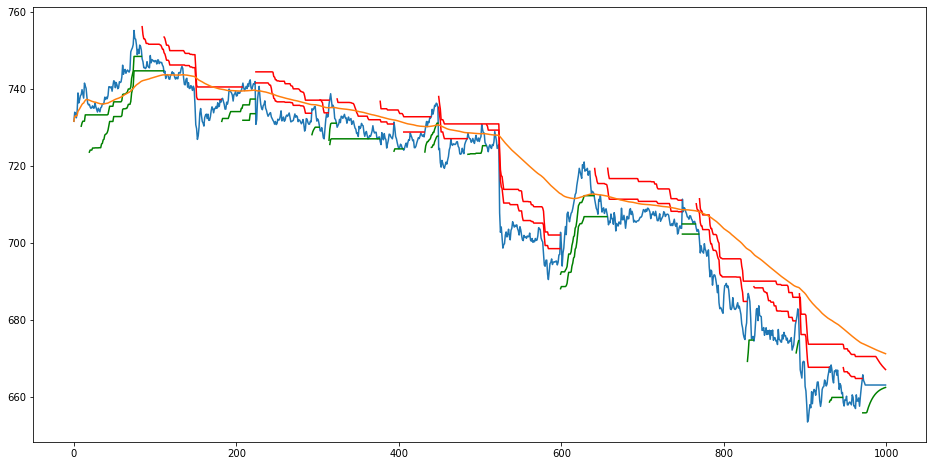

Buy ADANIPORTS shares at 733.55
Sell ADANIPORTS at 744.15
Buy ADANIPORTS shares at 741.45
Sell ADANIPORTS at 730.75
Buy ADANIPORTS shares at 737.3
Sell ADANIPORTS at 727.3
Buy ADANIPORTS shares at 732.8
Sell ADANIPORTS at 724.2
Buy ADANIPORTS shares at 702.75
Sell ADANIPORTS at 692.75
Buy ADANIPORTS shares at 711.35
Sell ADANIPORTS at 700.55
Earning from investing 100k is -51.5 (ROI = -0.05%)
p:l(number)=1:5
success % =16.666666666666664%
Avg win=10.600000000000023
Avg Loss=-10.020000000000005
APOLLOHOSP


					APOLLOHOSP


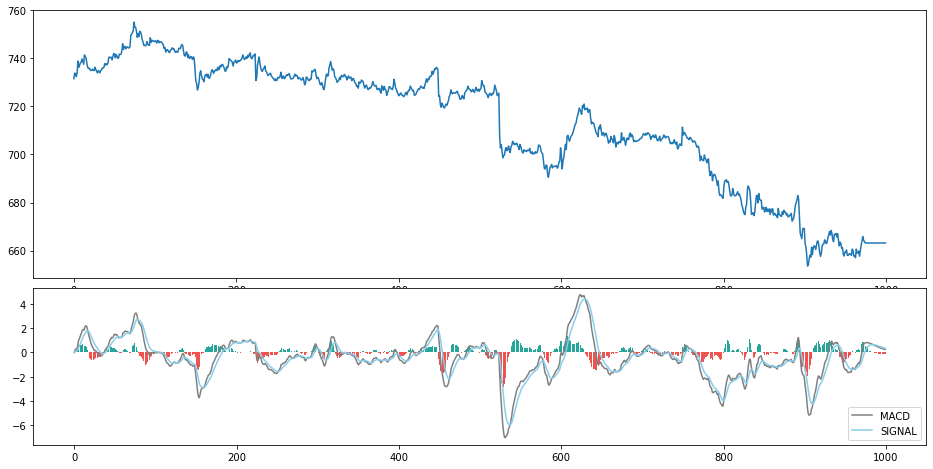

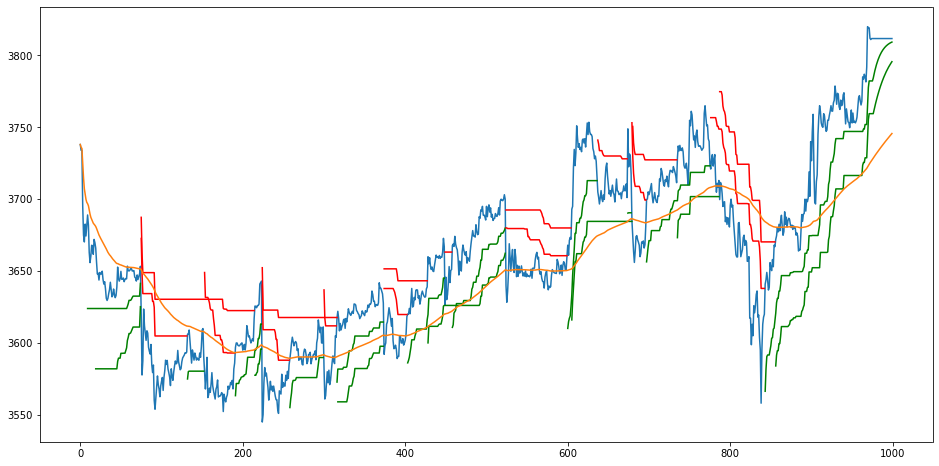

Buy APOLLOHOSP shares at 3734.0
Sell APOLLOHOSP at 3724.0
Buy APOLLOHOSP shares at 3675.0
Sell APOLLOHOSP at 3665.0
Buy APOLLOHOSP shares at 3655.85
Sell APOLLOHOSP at 3645.85
Buy APOLLOHOSP shares at 3648.0
Sell APOLLOHOSP at 3638.0
Buy APOLLOHOSP shares at 3631.1
Sell APOLLOHOSP at 3621.1
Buy APOLLOHOSP shares at 3633.0
Sell APOLLOHOSP at 3623.0
Buy APOLLOHOSP shares at 3644.2
Sell APOLLOHOSP at 3634.2
Buy APOLLOHOSP shares at 3647.3
Sell APOLLOHOSP at 3619.9
Buy APOLLOHOSP shares at 3625.65
Sell APOLLOHOSP at 3545.0
Buy APOLLOHOSP shares at 3622.0
Sell APOLLOHOSP at 3612.0
Buy APOLLOHOSP shares at 3613.55
Sell APOLLOHOSP at 3603.55
Buy APOLLOHOSP shares at 3618.05
Sell APOLLOHOSP at 3608.05
Buy APOLLOHOSP shares at 3626.4
Sell APOLLOHOSP at 3616.4
Buy APOLLOHOSP shares at 3659.95
Sell APOLLOHOSP at 3649.95
Buy APOLLOHOSP shares at 3654.0
Sell APOLLOHOSP at 3644.0
Buy APOLLOHOSP shares at 3667.7
Sell APOLLOHOSP at 3657.7
Buy APOLLOHOSP shares at 3647.25
Sell APOLLOHOSP at 3637.25
Buy

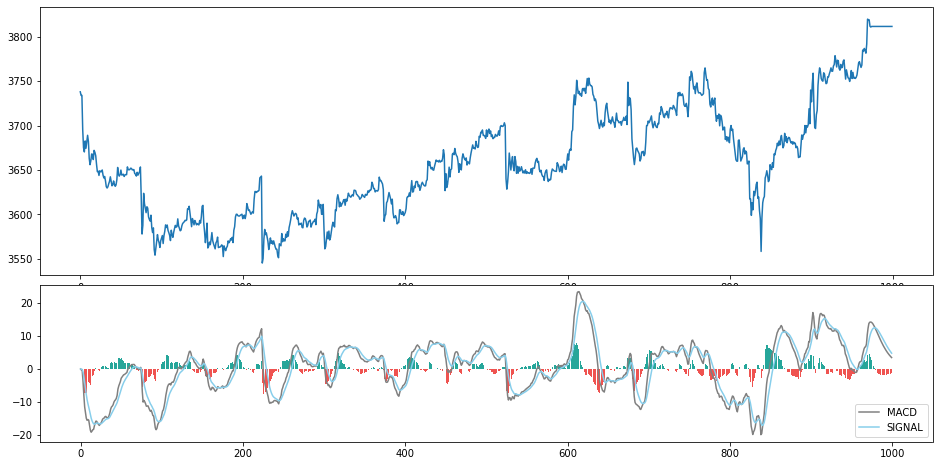

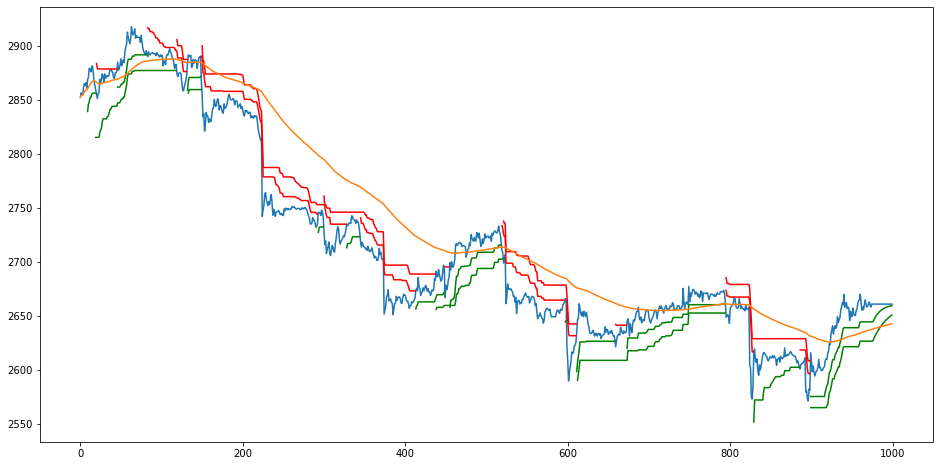

Buy ASIANPAINT shares at 2854.05
Sell ASIANPAINT at 2844.05
Buy ASIANPAINT shares at 2862.9
Sell ASIANPAINT at 2852.9
Buy ASIANPAINT shares at 2885.0
Sell ASIANPAINT at 2875.0
Buy ASIANPAINT shares at 2906.1
Sell ASIANPAINT at 2896.1
Buy ASIANPAINT shares at 2909.5
Sell ASIANPAINT at 2899.5
Buy ASIANPAINT shares at 2894.95
Sell ASIANPAINT at 2884.95
Buy ASIANPAINT shares at 2891.65
Sell ASIANPAINT at 2881.65
Buy ASIANPAINT shares at 2880.8
Sell ASIANPAINT at 2870.8
Buy ASIANPAINT shares at 2691.2
Sell ASIANPAINT at 2681.2
Buy ASIANPAINT shares at 2683.55
Sell ASIANPAINT at 2673.55
Buy ASIANPAINT shares at 2699.0
Sell ASIANPAINT at 2689.0
Buy ASIANPAINT shares at 2707.45
Sell ASIANPAINT at 2697.45
Buy ASIANPAINT shares at 2715.95
Sell ASIANPAINT at 2705.95
Buy ASIANPAINT shares at 2646.55
Sell ASIANPAINT at 2636.55
Buy ASIANPAINT shares at 2653.35
Sell ASIANPAINT at 2643.35
Buy ASIANPAINT shares at 2640.05
Sell ASIANPAINT at 2630.05
Buy ASIANPAINT shares at 2631.0
Sell ASIANPAINT at 262

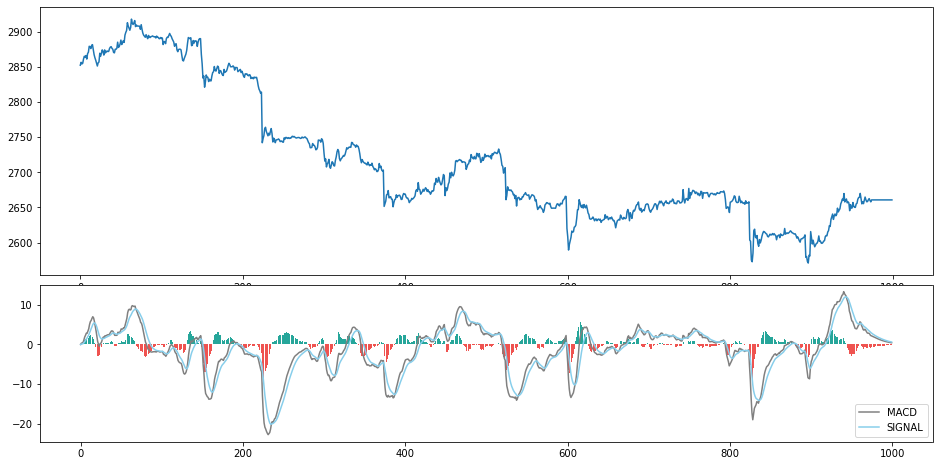

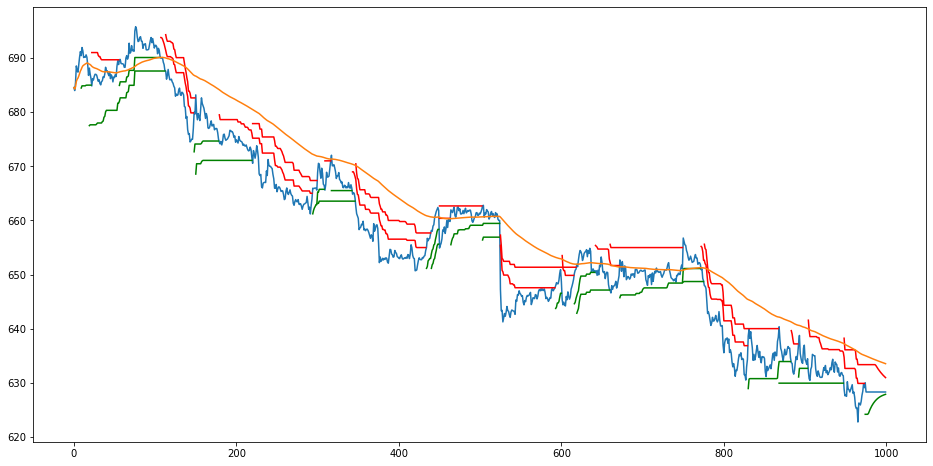

Buy AXISBANK shares at 685.5
Sell AXISBANK at 687.6
Buy AXISBANK shares at 683.2
Sell AXISBANK at 673.2
Buy AXISBANK shares at 668.9
Sell AXISBANK at 662.55
Buy AXISBANK shares at 658.15
Sell AXISBANK at 654.9
Buy AXISBANK shares at 662.7
Sell AXISBANK at 647.25
Buy AXISBANK shares at 651.9
Sell AXISBANK at 647.1
Buy AXISBANK shares at 656.75
Sell AXISBANK at 647.95
Buy AXISBANK shares at 640.35
Sell AXISBANK at 628.85
Earning from investing 100k is -74.05 (ROI = -0.07%)
p:l(number)=1:7
success % =12.5%
Avg win=2.1000000000000227
Avg Loss=-8.59285714285714
BAJAJ-AUTO


					BAJAJ-AUTO


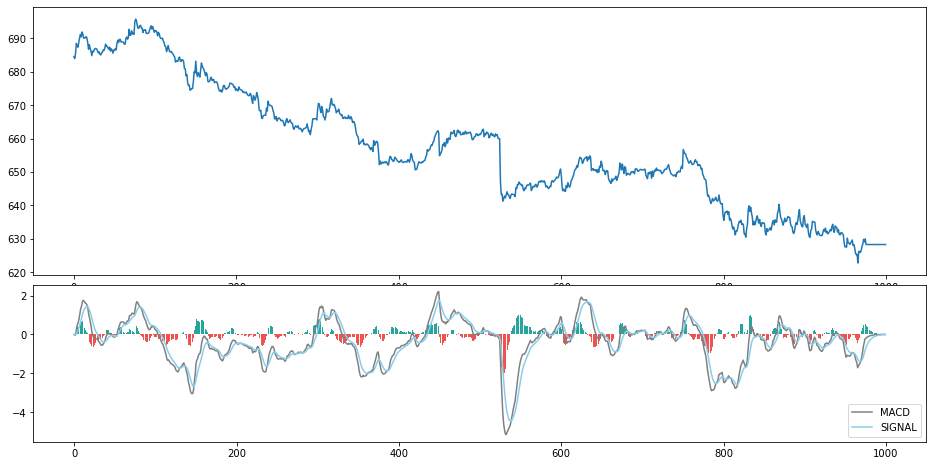

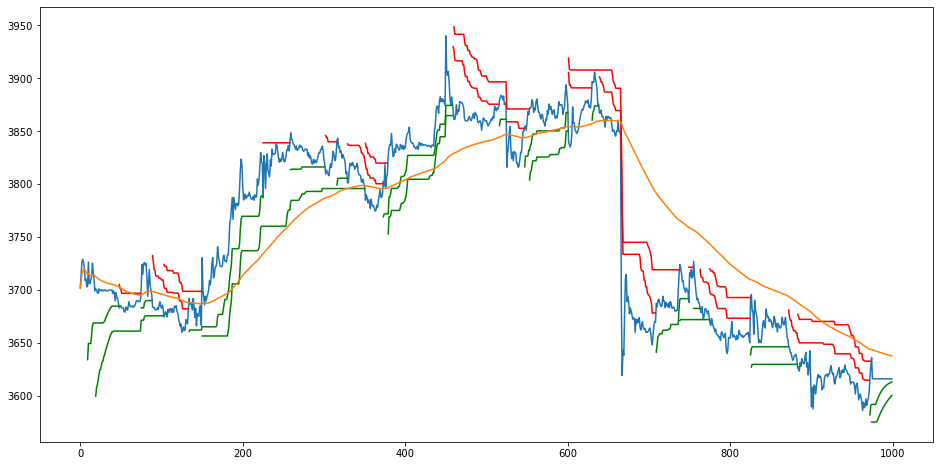

Buy BAJAJ-AUTO shares at 3726.35
Sell BAJAJ-AUTO at 3716.35
Buy BAJAJ-AUTO shares at 3710.3
Sell BAJAJ-AUTO at 3700.3
Buy BAJAJ-AUTO shares at 3706.05
Sell BAJAJ-AUTO at 3696.05
Buy BAJAJ-AUTO shares at 3699.0
Sell BAJAJ-AUTO at 3689.0
Buy BAJAJ-AUTO shares at 3697.5
Sell BAJAJ-AUTO at 3687.5
Buy BAJAJ-AUTO shares at 3701.8
Sell BAJAJ-AUTO at 3691.8
Buy BAJAJ-AUTO shares at 3694.05
Sell BAJAJ-AUTO at 3684.05
Buy BAJAJ-AUTO shares at 3699.7
Sell BAJAJ-AUTO at 3689.7
Buy BAJAJ-AUTO shares at 3730.4
Sell BAJAJ-AUTO at 3720.4
Buy BAJAJ-AUTO shares at 3692.7
Sell BAJAJ-AUTO at 3682.7
Buy BAJAJ-AUTO shares at 3713.65
Sell BAJAJ-AUTO at 3703.65
Buy BAJAJ-AUTO shares at 3723.0
Sell BAJAJ-AUTO at 3713.0
Buy BAJAJ-AUTO shares at 3787.4
Sell BAJAJ-AUTO at 3777.4
Buy BAJAJ-AUTO shares at 3781.8
Sell BAJAJ-AUTO at 3771.8
Buy BAJAJ-AUTO shares at 3785.0
Sell BAJAJ-AUTO at 3775.0
Buy BAJAJ-AUTO shares at 3848.5
Sell BAJAJ-AUTO at 3838.5
Buy BAJAJ-AUTO shares at 3837.75
Sell BAJAJ-AUTO at 3827.75
Buy 

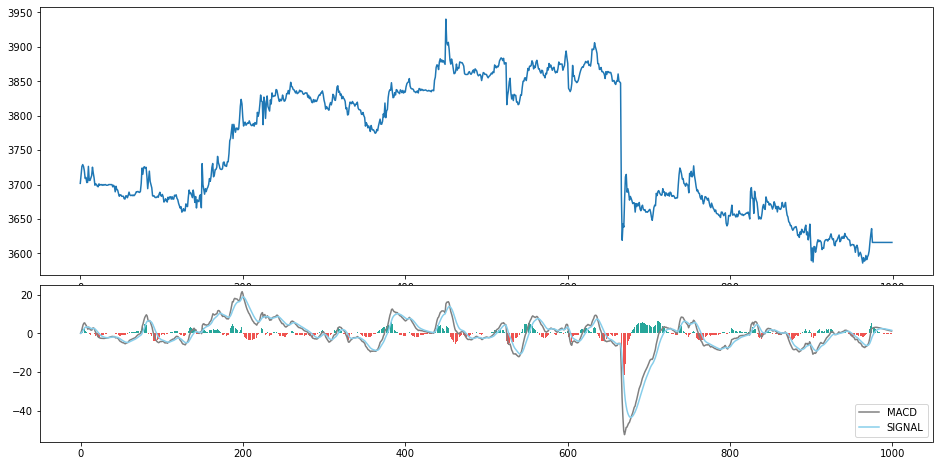

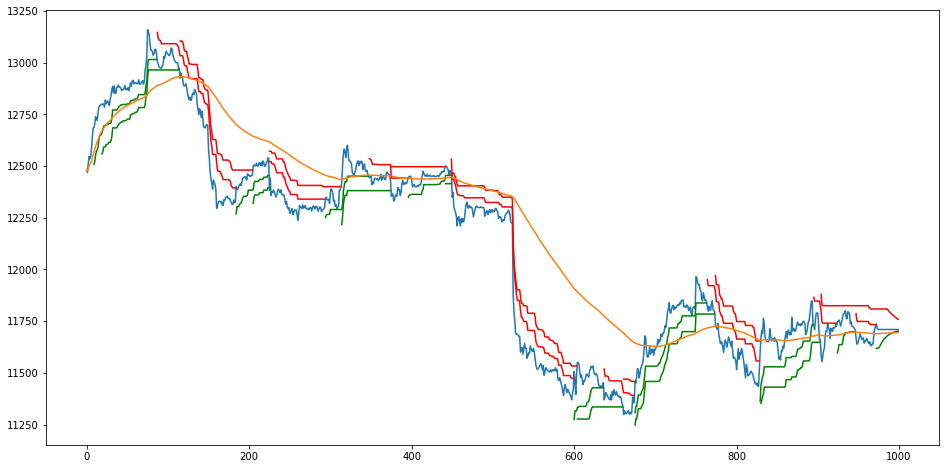

Buy BAJAJFINSV shares at 12513.25
Sell BAJAJFINSV at 12503.25
Buy BAJAJFINSV shares at 12544.8
Sell BAJAJFINSV at 12534.8
Buy BAJAJFINSV shares at 12721.0
Sell BAJAJFINSV at 12711.0
Buy BAJAJFINSV shares at 12820.0
Sell BAJAJFINSV at 12810.0
Buy BAJAJFINSV shares at 12810.0
Sell BAJAJFINSV at 12800.0
Buy BAJAJFINSV shares at 12792.8
Sell BAJAJFINSV at 12782.8
Buy BAJAJFINSV shares at 12887.85
Sell BAJAJFINSV at 12877.85
Buy BAJAJFINSV shares at 12850.75
Sell BAJAJFINSV at 12840.75
Buy BAJAJFINSV shares at 12880.5
Sell BAJAJFINSV at 12870.5
Buy BAJAJFINSV shares at 12868.0
Sell BAJAJFINSV at 12858.0
Buy BAJAJFINSV shares at 12874.05
Sell BAJAJFINSV at 12864.05
Buy BAJAJFINSV shares at 12881.7
Sell BAJAJFINSV at 12871.7
Buy BAJAJFINSV shares at 12910.9
Sell BAJAJFINSV at 12900.9
Buy BAJAJFINSV shares at 12900.9
Sell BAJAJFINSV at 12890.9
Buy BAJAJFINSV shares at 12895.0
Sell BAJAJFINSV at 12885.0
Buy BAJAJFINSV shares at 12910.0
Sell BAJAJFINSV at 12900.0
Buy BAJAJFINSV shares at 13093.2

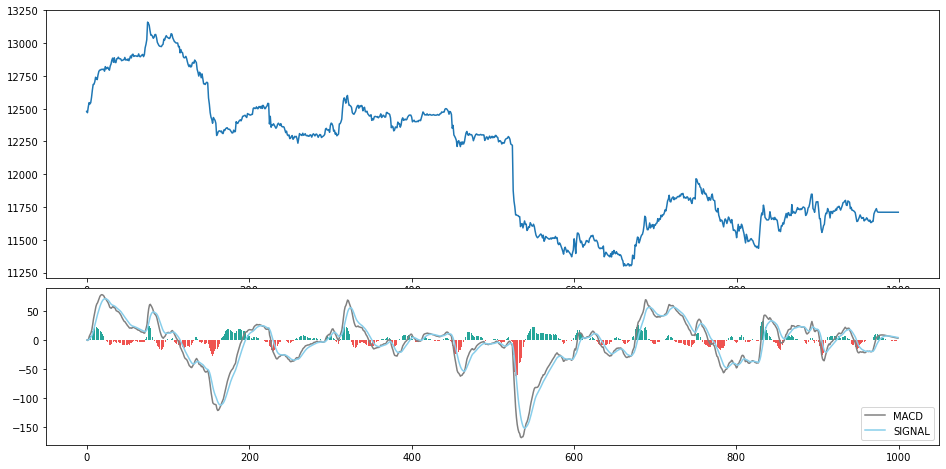

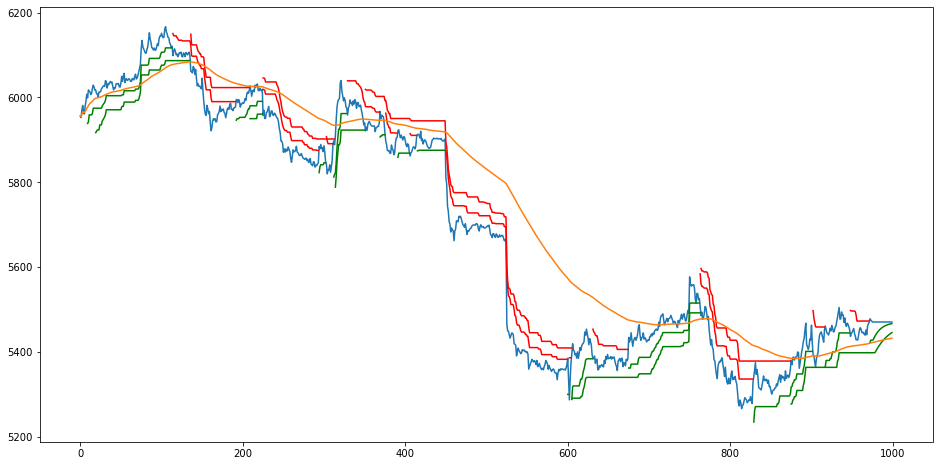

Buy BAJFINANCE shares at 5971.0
Sell BAJFINANCE at 5961.0
Buy BAJFINANCE shares at 5961.05
Sell BAJFINANCE at 5951.05
Buy BAJFINANCE shares at 6010.15
Sell BAJFINANCE at 6000.15
Buy BAJFINANCE shares at 6017.85
Sell BAJFINANCE at 6007.85
Buy BAJFINANCE shares at 6013.0
Sell BAJFINANCE at 6003.0
Buy BAJFINANCE shares at 6031.9
Sell BAJFINANCE at 6021.9
Buy BAJFINANCE shares at 6017.95
Sell BAJFINANCE at 6007.95
Buy BAJFINANCE shares at 6049.35
Sell BAJFINANCE at 6039.35
Buy BAJFINANCE shares at 6043.05
Sell BAJFINANCE at 6033.05
Buy BAJFINANCE shares at 6046.0
Sell BAJFINANCE at 6036.0
Buy BAJFINANCE shares at 6114.3
Sell BAJFINANCE at 6104.3
Buy BAJFINANCE shares at 6129.9
Sell BAJFINANCE at 6119.9
Buy BAJFINANCE shares at 6116.15
Sell BAJFINANCE at 6106.15
Buy BAJFINANCE shares at 6142.0
Sell BAJFINANCE at 6132.0
Buy BAJFINANCE shares at 6149.5
Sell BAJFINANCE at 6139.5
Buy BAJFINANCE shares at 6125.0
Sell BAJFINANCE at 6115.0
Buy BAJFINANCE shares at 6027.35
Sell BAJFINANCE at 6017.3

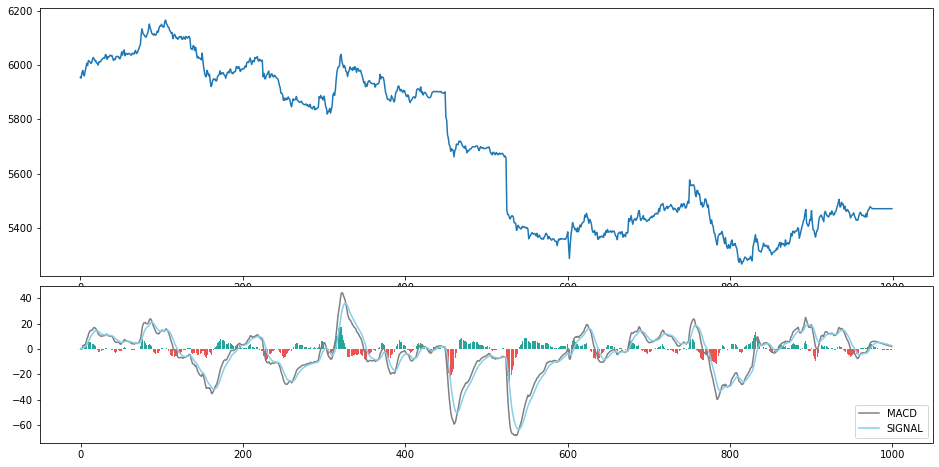

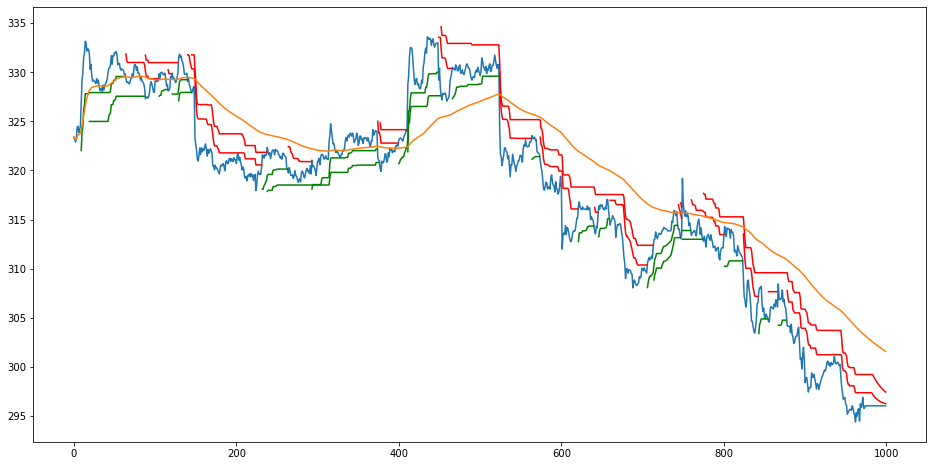

Buy BPCL shares at 322.9
Sell BPCL at 327.3
Buy BPCL shares at 331.5
Sell BPCL at 327.9
Buy BPCL shares at 322.35
Sell BPCL at 320.2
Buy BPCL shares at 328.75
Sell BPCL at 327.6
Buy BPCL shares at 312.95
Sell BPCL at 313.05
Buy BPCL shares at 319.2
Sell BPCL at 312.8
Earning from investing 100k is -20.8 (ROI = -0.02%)
p:l(number)=2:4
success % =33.33333333333333%
Avg win=2.2500000000000284
Avg Loss=-3.325000000000003
BHARTIARTL


					BHARTIARTL


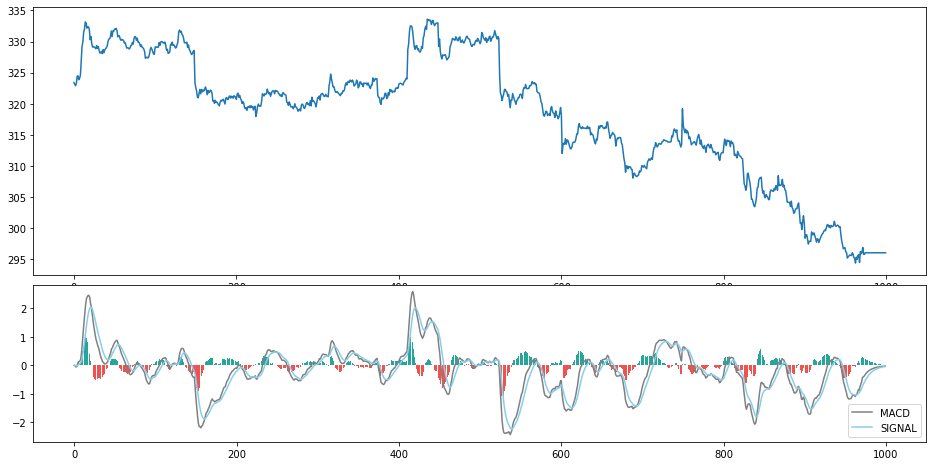

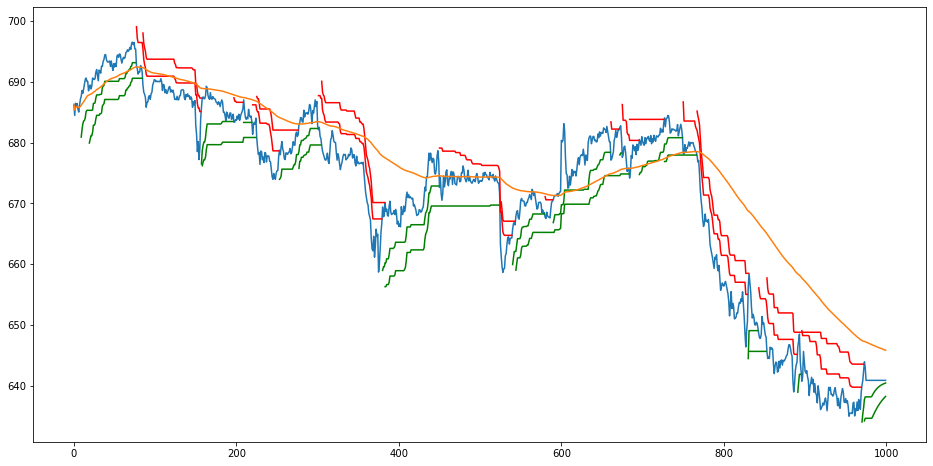

Buy BHARTIARTL shares at 686.45
Sell BHARTIARTL at 689.4
Buy BHARTIARTL shares at 687.35
Sell BHARTIARTL at 680.8
Buy BHARTIARTL shares at 683.0
Sell BHARTIARTL at 679.5
Buy BHARTIARTL shares at 670.15
Sell BHARTIARTL at 663.25
Buy BHARTIARTL shares at 667.85
Sell BHARTIARTL at 657.85
Buy BHARTIARTL shares at 672.6
Sell BHARTIARTL at 674.15
Buy BHARTIARTL shares at 684.05
Sell BHARTIARTL at 677.9
Buy BHARTIARTL shares at 658.5
Sell BHARTIARTL at 648.5
Buy BHARTIARTL shares at 643.95
Sell BHARTIARTLat 640.9 
Earning from investing 100k is -59.65 (ROI = -0.06%)
p:l(number)=3:6
success % =33.33333333333333%
Avg win=0.4833333333332727
Avg Loss=-7.183333333333337
BRITANNIA


					BRITANNIA


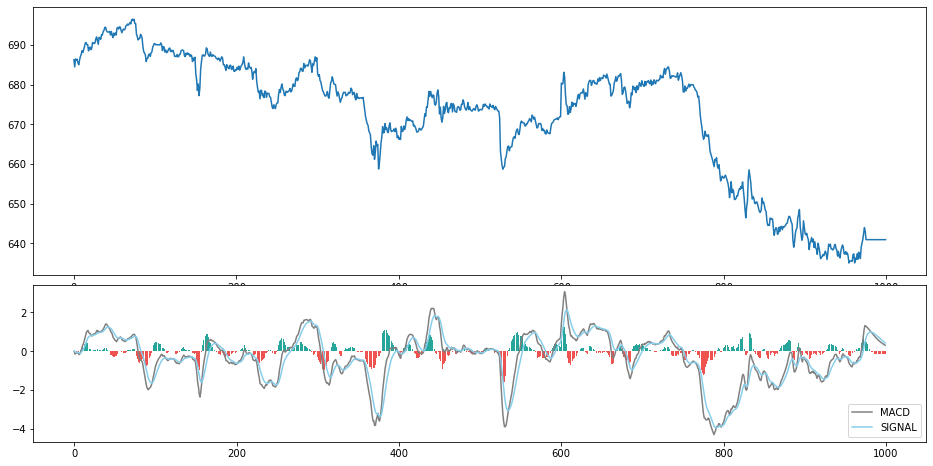

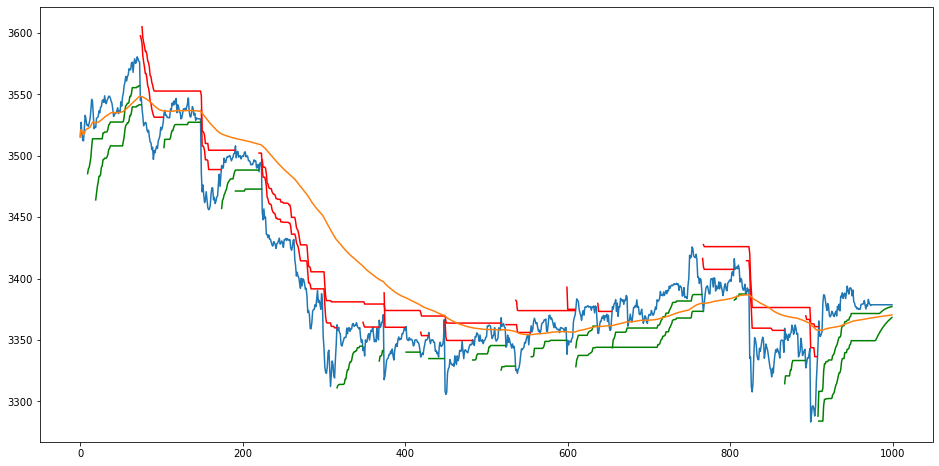

Buy BRITANNIA shares at 3518.5
Sell BRITANNIA at 3508.5
Buy BRITANNIA shares at 3522.0
Sell BRITANNIA at 3512.0
Buy BRITANNIA shares at 3532.0
Sell BRITANNIA at 3522.0
Buy BRITANNIA shares at 3508.0
Sell BRITANNIA at 3498.0
Buy BRITANNIA shares at 3499.35
Sell BRITANNIA at 3489.35
Buy BRITANNIA shares at 3493.0
Sell BRITANNIA at 3454.05
Buy BRITANNIA shares at 3368.05
Sell BRITANNIA at 3358.05
Buy BRITANNIA shares at 3375.5
Sell BRITANNIA at 3365.5
Buy BRITANNIA shares at 3369.85
Sell BRITANNIA at 3359.85
Buy BRITANNIA shares at 3377.0
Sell BRITANNIA at 3367.0
Buy BRITANNIA shares at 3377.0
Sell BRITANNIA at 3367.0
Buy BRITANNIA shares at 3364.95
Sell BRITANNIA at 3354.95
Buy BRITANNIA shares at 3370.5
Sell BRITANNIA at 3360.5
Buy BRITANNIA shares at 3366.0
Sell BRITANNIA at 3356.0
Buy BRITANNIA shares at 3386.55
Sell BRITANNIA at 3376.55
Buy BRITANNIA shares at 3400.95
Sell BRITANNIA at 3390.95
Buy BRITANNIA shares at 3365.45
Sell BRITANNIA at 3355.45
Buy BRITANNIA shares at 3352.75
S

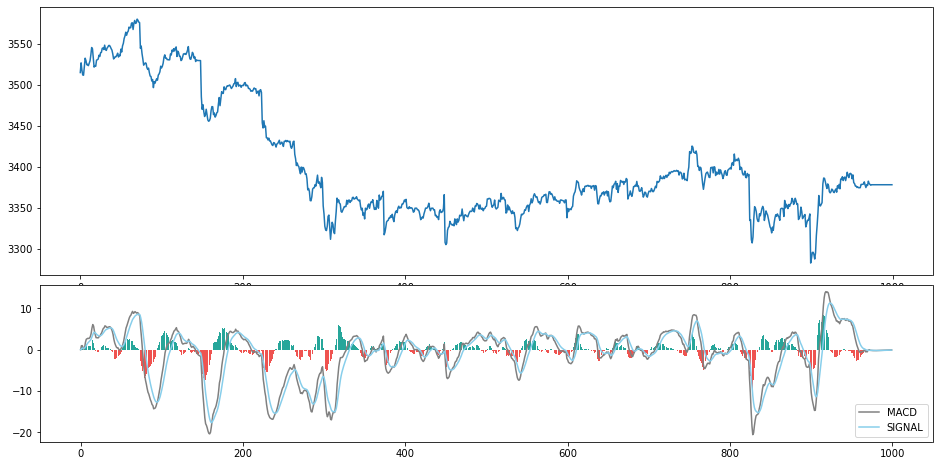

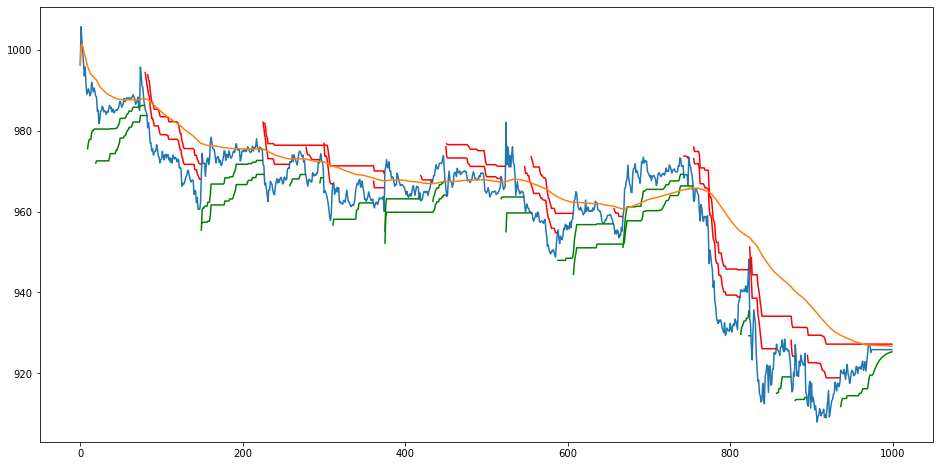

Buy CIPLA shares at 1002.25
Sell CIPLA at 992.25
Buy CIPLA shares at 989.0
Sell CIPLA at 979.0
Buy CIPLA shares at 982.6
Sell CIPLA at 972.6
Buy CIPLA shares at 974.4
Sell CIPLA at 966.55
Buy CIPLA shares at 970.1
Sell CIPLA at 960.1
Buy CIPLA shares at 967.85
Sell CIPLA at 963.75
Buy CIPLA shares at 982.05
Sell CIPLA at 972.05
Buy CIPLA shares at 976.0
Sell CIPLA at 966.0
Buy CIPLA shares at 965.65
Sell CIPLA at 959.6
Buy CIPLA shares at 960.5
Sell CIPLA at 950.5
Buy CIPLA shares at 958.8
Sell CIPLA at 962.5
Buy CIPLA shares at 948.25
Sell CIPLA at 938.25
Earning from investing 100k is -118.3 (ROI = -0.12%)
p:l(number)=1:11
success % =8.333333333333332%
Avg win=3.7000000000000455
Avg Loss=-8.909090909090908
COALINDIA


					COALINDIA


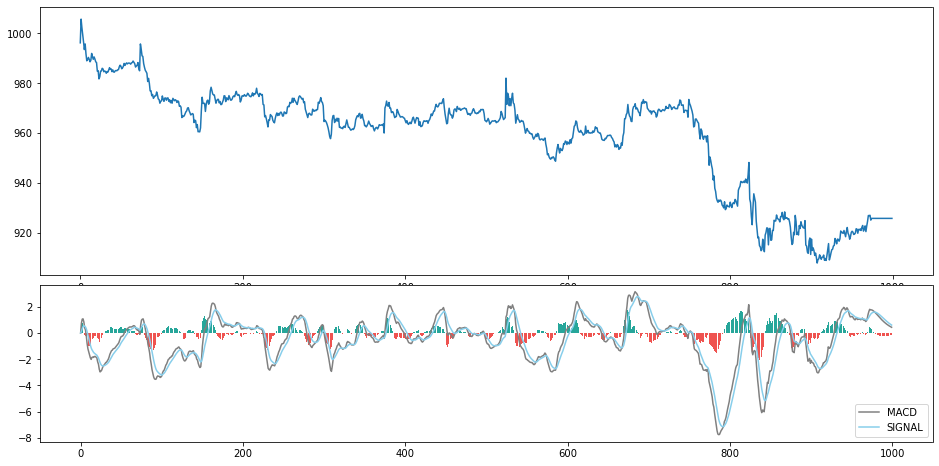

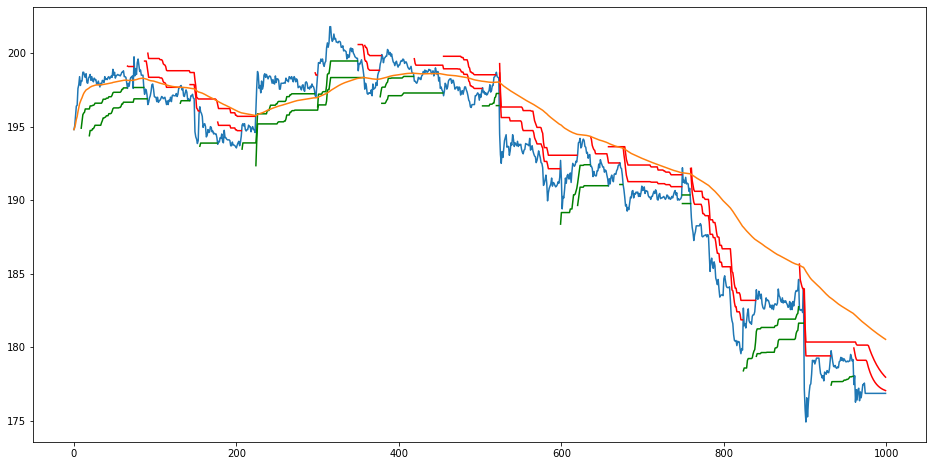

Buy COALINDIA shares at 195.7
Sell COALINDIA at 196.5
Buy COALINDIA shares at 196.2
Sell COALINDIA at 197.55
Buy COALINDIA shares at 199.9
Sell COALINDIA at 197.1
Buy COALINDIA shares at 198.7
Sell COALINDIA at 194.5
Buy COALINDIA shares at 193.1
Sell COALINDIA at 190.95
Buy COALINDIA shares at 192.2
Sell COALINDIA at 188.8
Buy COALINDIA shares at 183.9
Sell COALINDIA at 177.15
Earning from investing 100k is -31.15 (ROI = -0.03%)
p:l(number)=2:5
success % =28.57142857142857%
Avg win=1.075000000000017
Avg Loss=-3.8599999999999968
DRREDDY


					DRREDDY


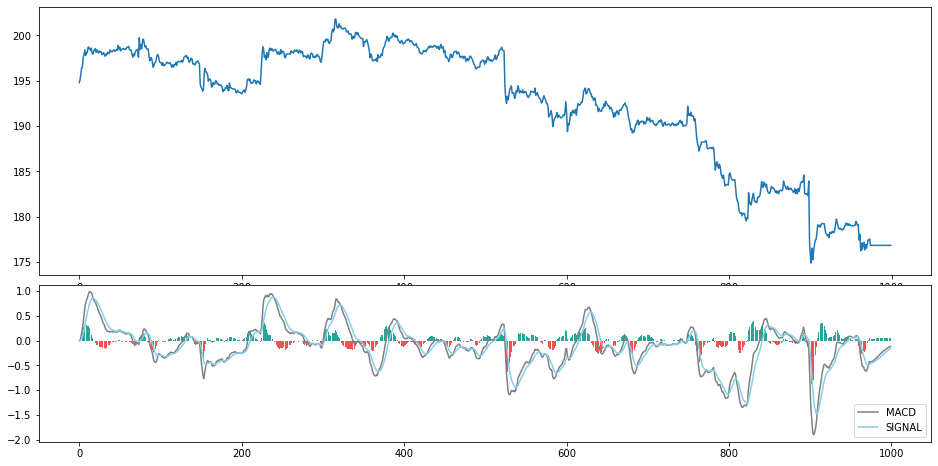

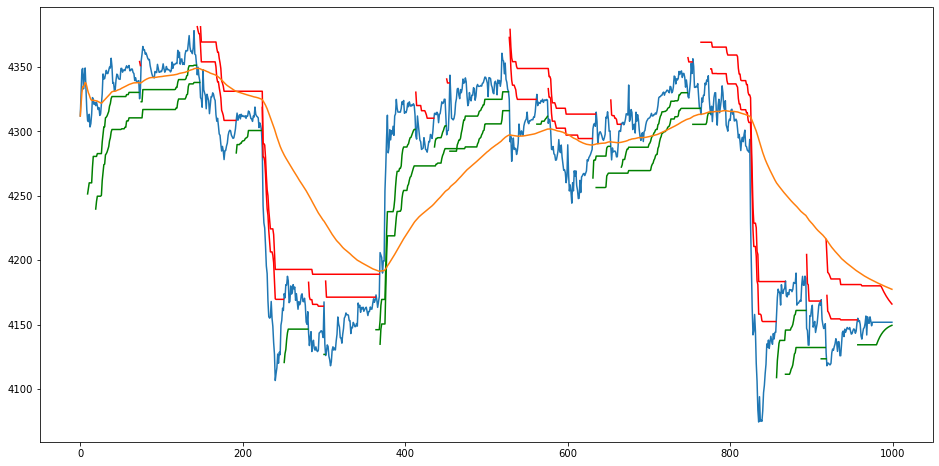

Buy DRREDDY shares at 4348.0
Sell DRREDDY at 4338.0
Buy DRREDDY shares at 4343.2
Sell DRREDDY at 4333.2
Buy DRREDDY shares at 4317.0
Sell DRREDDY at 4307.0
Buy DRREDDY shares at 4306.1
Sell DRREDDY at 4296.1
Buy DRREDDY shares at 4313.5
Sell DRREDDY at 4303.5
Buy DRREDDY shares at 4338.0
Sell DRREDDY at 4328.0
Buy DRREDDY shares at 4341.75
Sell DRREDDY at 4331.75
Buy DRREDDY shares at 4355.0
Sell DRREDDY at 4345.0
Buy DRREDDY shares at 4355.95
Sell DRREDDY at 4345.95
Buy DRREDDY shares at 4342.9
Sell DRREDDY at 4332.9
Buy DRREDDY shares at 4356.05
Sell DRREDDY at 4346.05
Buy DRREDDY shares at 4362.25
Sell DRREDDY at 4352.25
Buy DRREDDY shares at 4359.4
Sell DRREDDY at 4349.4
Buy DRREDDY shares at 4205.9
Sell DRREDDY at 4195.9
Buy DRREDDY shares at 4199.4
Sell DRREDDY at 4189.4
Buy DRREDDY shares at 4287.65
Sell DRREDDY at 4277.65
Buy DRREDDY shares at 4315.0
Sell DRREDDY at 4305.0
Buy DRREDDY shares at 4314.0
Sell DRREDDY at 4304.0
Buy DRREDDY shares at 4343.7
Sell DRREDDY at 4333.7
Bu

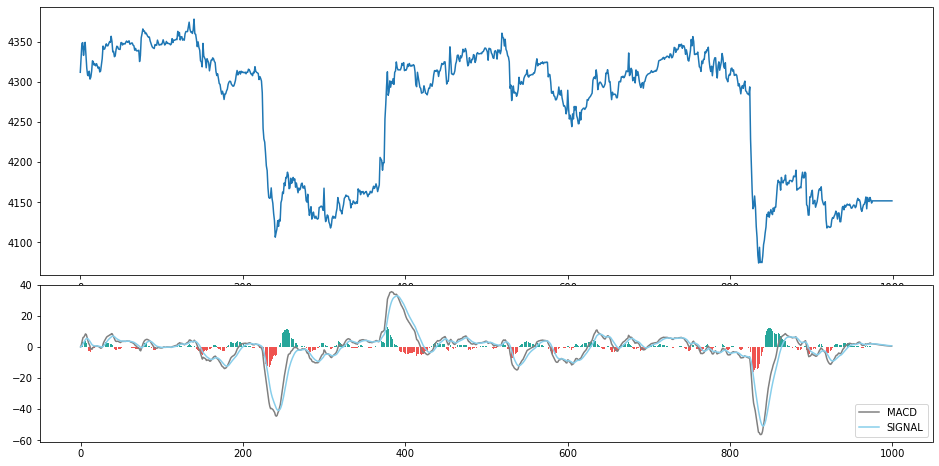

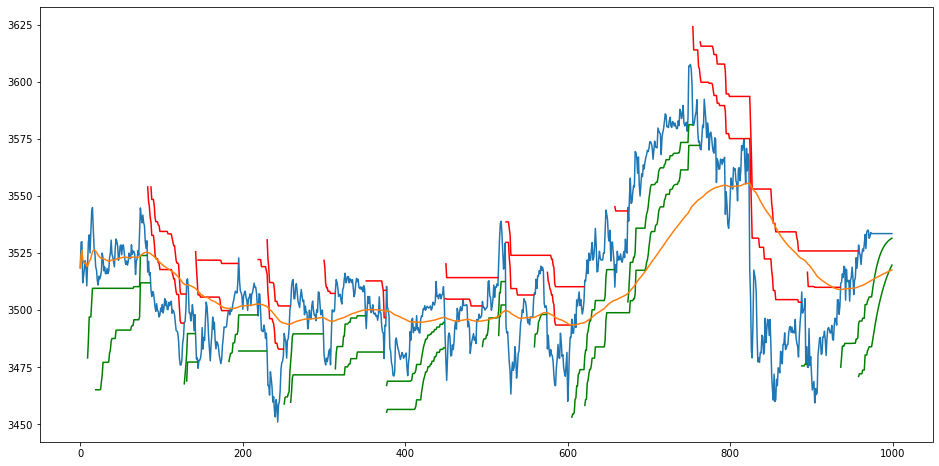

Buy DIVISLAB shares at 3530.0
Sell DIVISLAB at 3520.0
Buy DIVISLAB shares at 3514.8
Sell DIVISLAB at 3504.8
Buy DIVISLAB shares at 3520.2
Sell DIVISLAB at 3510.2
Buy DIVISLAB shares at 3524.85
Sell DIVISLAB at 3514.85
Buy DIVISLAB shares at 3511.0
Sell DIVISLAB at 3501.0
Buy DIVISLAB shares at 3526.85
Sell DIVISLAB at 3516.85
Buy DIVISLAB shares at 3521.55
Sell DIVISLAB at 3511.55
Buy DIVISLAB shares at 3521.5
Sell DIVISLAB at 3511.5
Buy DIVISLAB shares at 3527.05
Sell DIVISLAB at 3517.05
Buy DIVISLAB shares at 3513.0
Sell DIVISLAB at 3503.0
Buy DIVISLAB shares at 3498.9
Sell DIVISLAB at 3488.9
Buy DIVISLAB shares at 3498.1
Sell DIVISLAB at 3488.1
Buy DIVISLAB shares at 3522.9
Sell DIVISLAB at 3512.9
Buy DIVISLAB shares at 3507.7
Sell DIVISLAB at 3497.7
Buy DIVISLAB shares at 3502.3
Sell DIVISLAB at 3492.3
Buy DIVISLAB shares at 3501.15
Sell DIVISLAB at 3491.15
Buy DIVISLAB shares at 3501.8
Sell DIVISLAB at 3491.8
Buy DIVISLAB shares at 3508.3
Sell DIVISLAB at 3498.3
Buy DIVISLAB share

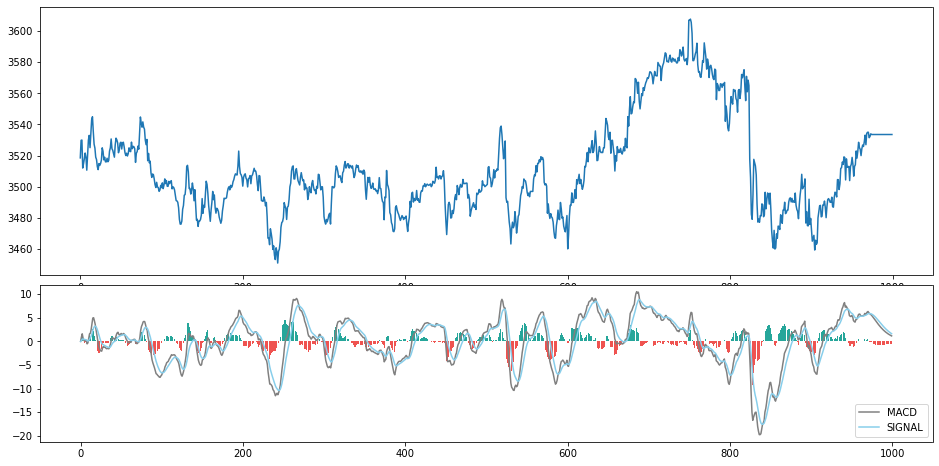

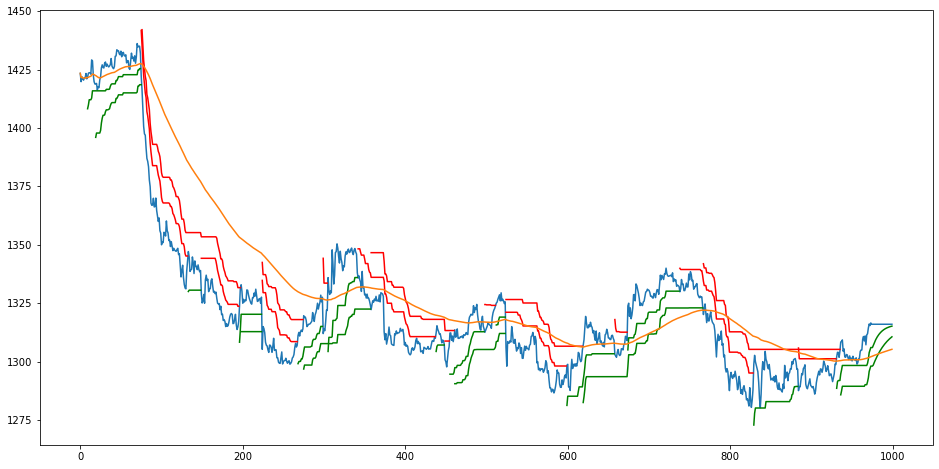

Buy GRASIM shares at 1421.9
Sell GRASIM at 1411.9
Buy GRASIM shares at 1418.8
Sell GRASIM at 1408.8
Buy GRASIM shares at 1332.9
Sell GRASIM at 1305.25
Buy GRASIM shares at 1319.65
Sell GRASIM at 1309.65
Buy GRASIM shares at 1335.95
Sell GRASIM at 1325.95
Buy GRASIM shares at 1336.95
Sell GRASIM at 1326.95
Buy GRASIM shares at 1340.95
Sell GRASIM at 1330.95
Buy GRASIM shares at 1313.65
Sell GRASIM at 1303.65
Buy GRASIM shares at 1313.5
Sell GRASIM at 1306.0
Buy GRASIM shares at 1307.0
Sell GRASIM at 1297.0
Buy GRASIM shares at 1313.1
Sell GRASIM at 1303.1
Buy GRASIM shares at 1323.85
Sell GRASIM at 1313.85
Buy GRASIM shares at 1308.4
Sell GRASIM at 1298.4
Buy GRASIM shares at 1299.55
Sell GRASIMat 1316.0 
Earning from investing 100k is -156.7 (ROI = -0.16%)
p:l(number)=0:14
success % =0.0%
Avg Loss=-9.192857142857147
HCLTECH


					HCLTECH


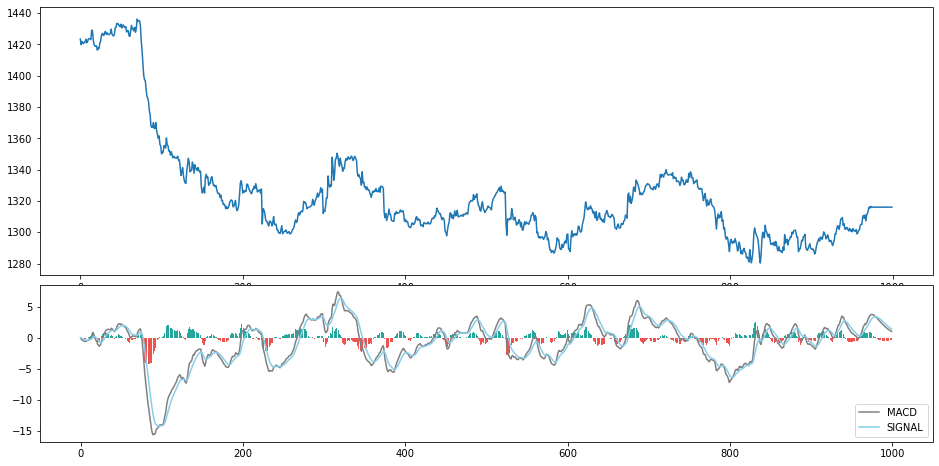

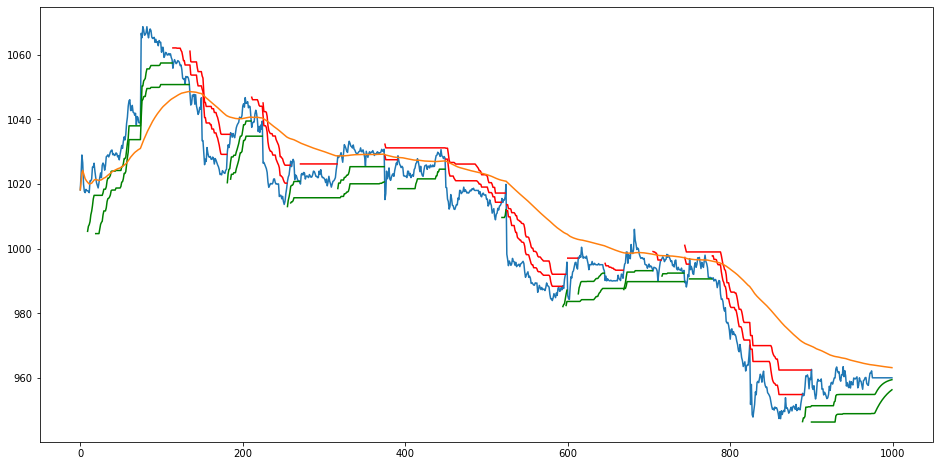

Buy HCLTECH shares at 1029.0
Sell HCLTECH at 1019.0
Buy HCLTECH shares at 1017.35
Sell HCLTECH at 1007.35
Buy HCLTECH shares at 1035.9
Sell HCLTECH at 1025.9
Buy HCLTECH shares at 1027.1
Sell HCLTECH at 1015.2
Buy HCLTECH shares at 1019.9
Sell HCLTECH at 998.3
Buy HCLTECH shares at 992.15
Sell HCLTECH at 982.15
Buy HCLTECH shares at 997.35
Sell HCLTECH at 987.35
Buy HCLTECH shares at 993.55
Sell HCLTECH at 983.55
Buy HCLTECH shares at 995.0
Sell HCLTECH at 989.5
Buy HCLTECH shares at 962.65
Sell HCLTECHat 960.05 
Earning from investing 100k is -121.6 (ROI = -0.12%)
p:l(number)=1:9
success % =10.0%
Avg win=-2.6000000000000227
Avg Loss=-10.999999999999988
HDFC


					HDFC


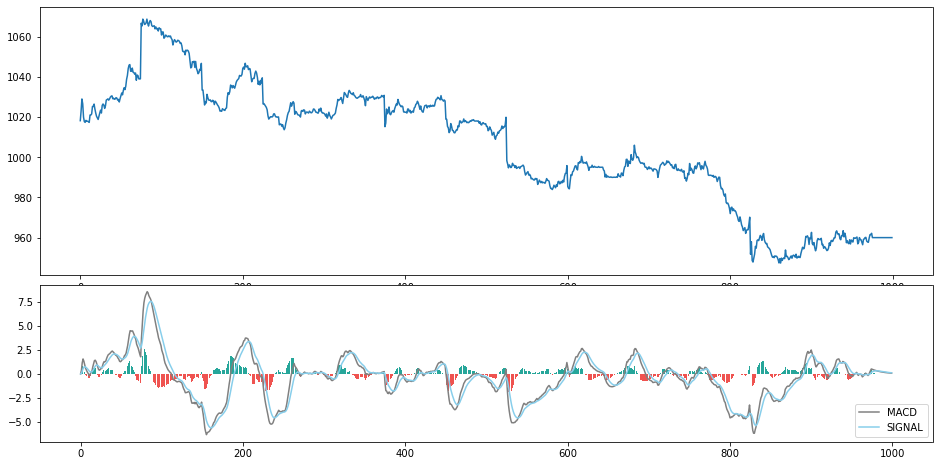

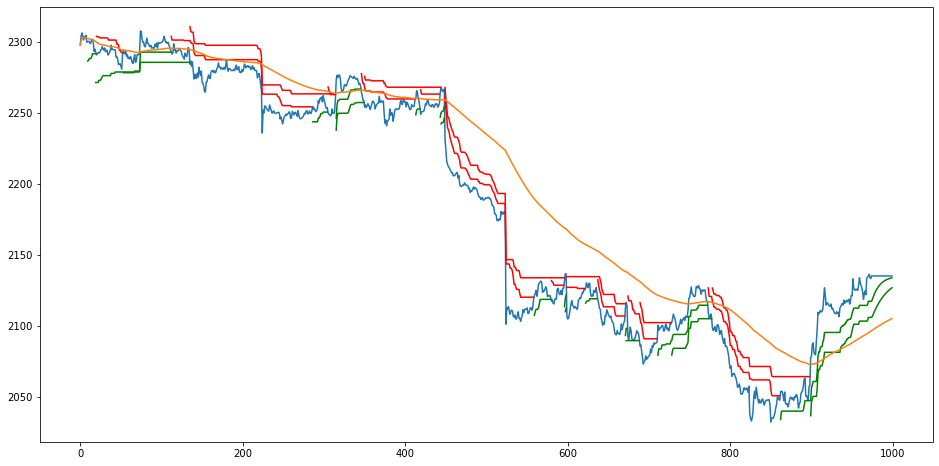

Buy HDFC shares at 2306.6
Sell HDFC at 2296.6
Buy HDFC shares at 2295.0
Sell HDFC at 2285.0
Buy HDFC shares at 2294.45
Sell HDFC at 2284.45
Buy HDFC shares at 2296.7
Sell HDFC at 2286.7
Buy HDFC shares at 2273.25
Sell HDFC at 2263.25
Buy HDFC shares at 2265.5
Sell HDFC at 2255.5
Buy HDFC shares at 2268.4
Sell HDFC at 2231.1
Buy HDFC shares at 2136.85
Sell HDFC at 2106.5
Buy HDFC shares at 2116.65
Sell HDFC at 2106.65
Buy HDFC shares at 2102.45
Sell HDFC at 2092.45
Buy HDFC shares at 2096.95
Sell HDFC at 2086.95
Buy HDFC shares at 2116.9
Sell HDFC at 2106.9
Buy HDFC shares at 2077.8
Sell HDFC at 2067.8
Buy HDFC shares at 2116.25
Sell HDFC at 2106.25
Buy HDFC shares at 2118.85
Sell HDFCat 2135.25 
Earning from investing 100k is -201.25 (ROI = -0.2%)
p:l(number)=0:15
success % =0.0%
Avg Loss=-11.416666666666666
HDFCBANK


					HDFCBANK


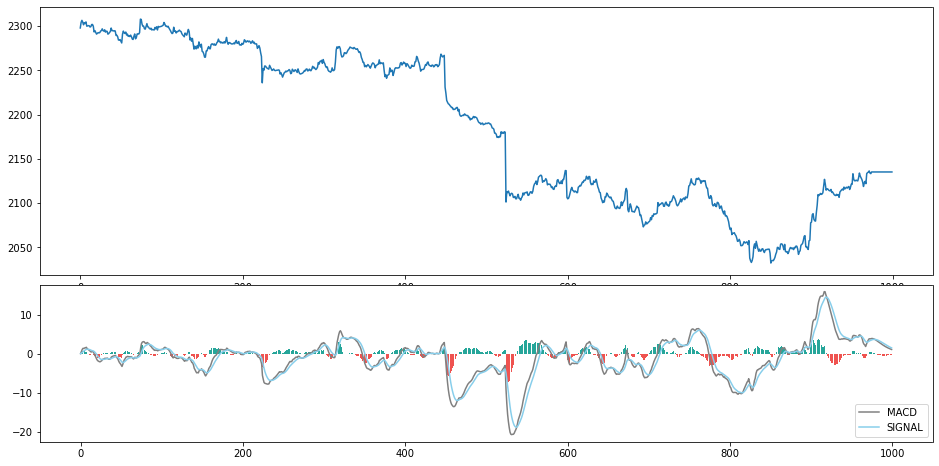

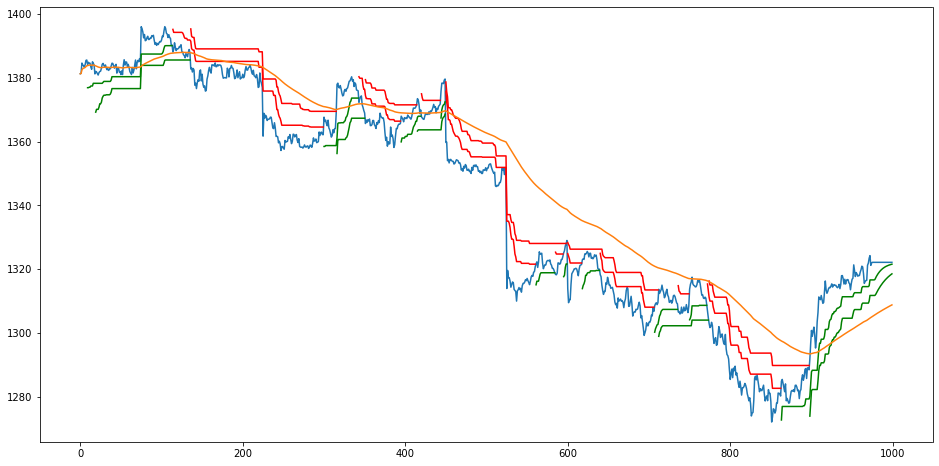

Buy HDFCBANK shares at 1384.6
Sell HDFCBANK at 1382.75
Buy HDFCBANK shares at 1377.9
Sell HDFCBANK at 1367.9
Buy HDFCBANK shares at 1373.45
Sell HDFCBANK at 1359.7
Buy HDFCBANK shares at 1329.0
Sell HDFCBANK at 1313.9
Buy HDFCBANK shares at 1313.7
Sell HDFCBANK at 1303.7
Buy HDFCBANK shares at 1291.85
Sell HDFCBANKat 1322.15 
Earning from investing 100k is -32.4 (ROI = -0.03%)
p:l(number)=1:5
success % =16.666666666666664%
Avg win=30.300000000000182
Avg Loss=-10.139999999999963
HDFCLIFE


					HDFCLIFE


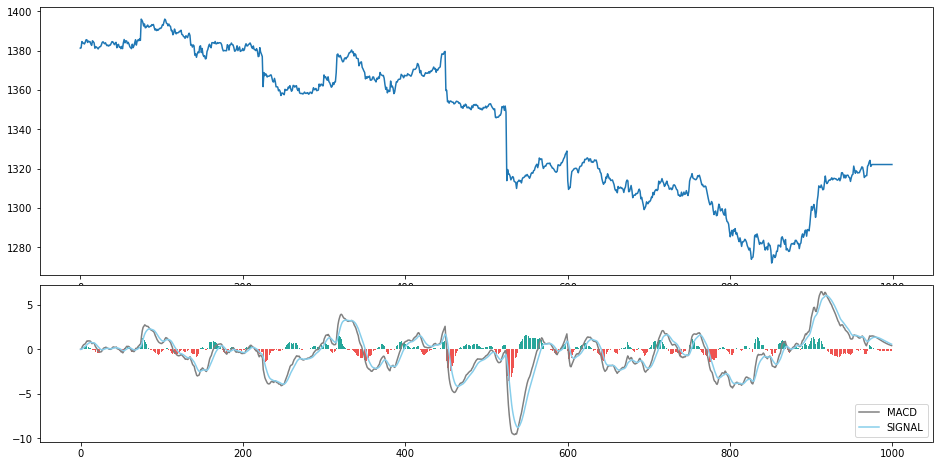

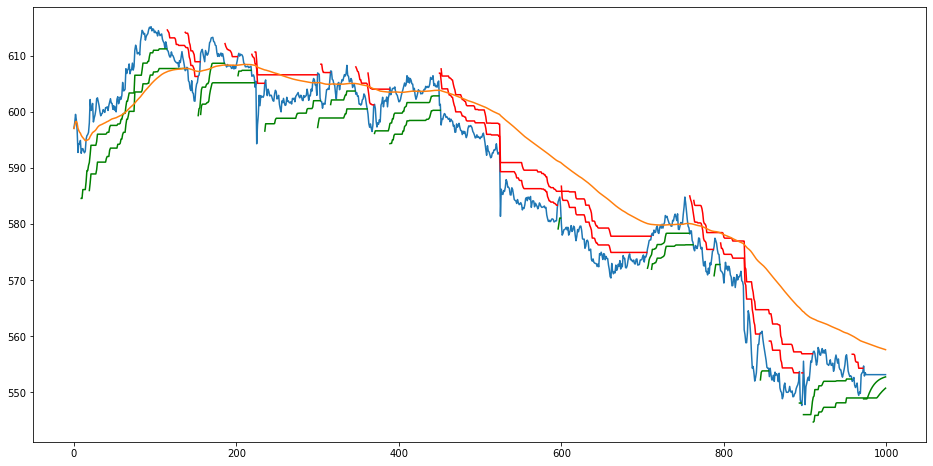

Buy HDFCLIFE shares at 599.6
Sell HDFCLIFE at 607.4
Buy HDFCLIFE shares at 610.5
Sell HDFCLIFE at 604.45
Buy HDFCLIFE shares at 607.0
Sell HDFCLIFE at 599.65
Buy HDFCLIFE shares at 604.45
Sell HDFCLIFE at 597.7
Buy HDFCLIFE shares at 578.1
Sell HDFCLIFE at 575.6
Buy HDFCLIFE shares at 557.2
Sell HDFCLIFEat 553.15 
Earning from investing 100k is -30.9 (ROI = -0.03%)
p:l(number)=2:4
success % =33.33333333333333%
Avg win=1.8749999999999432
Avg Loss=-5.662499999999994
HEROMOTOCO


					HEROMOTOCO


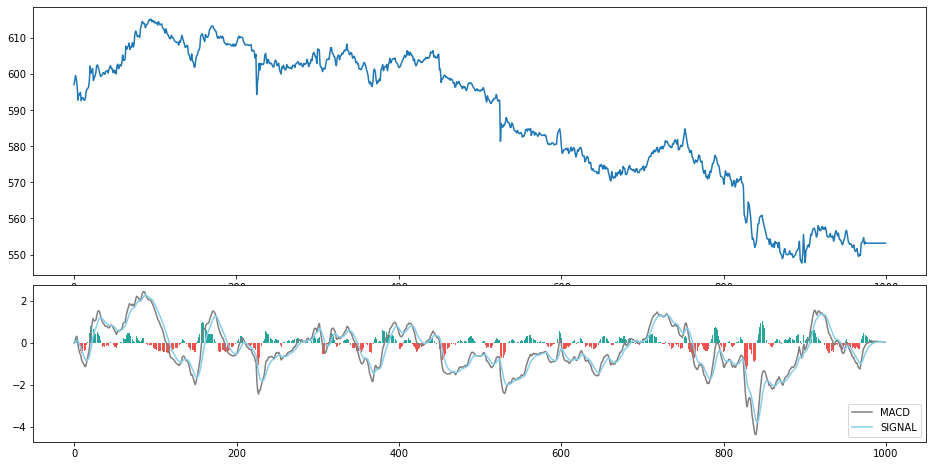

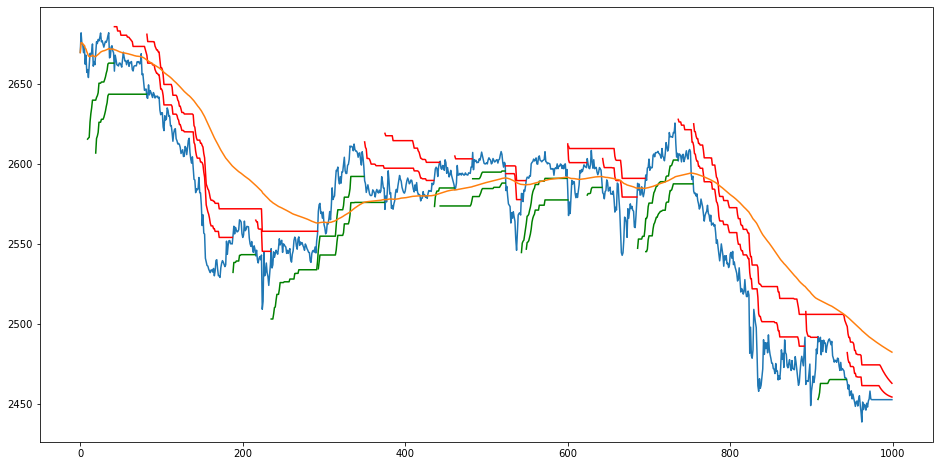

Buy HEROMOTOCO shares at 2675.0
Sell HEROMOTOCO at 2665.0
Buy HEROMOTOCO shares at 2668.0
Sell HEROMOTOCO at 2658.0
Buy HEROMOTOCO shares at 2659.0
Sell HEROMOTOCO at 2649.0
Buy HEROMOTOCO shares at 2664.0
Sell HEROMOTOCO at 2654.0
Buy HEROMOTOCO shares at 2667.0
Sell HEROMOTOCO at 2657.0
Buy HEROMOTOCO shares at 2570.25
Sell HEROMOTOCO at 2560.25
Buy HEROMOTOCO shares at 2560.05
Sell HEROMOTOCO at 2550.05
Buy HEROMOTOCO shares at 2592.0
Sell HEROMOTOCO at 2582.0
Buy HEROMOTOCO shares at 2594.05
Sell HEROMOTOCO at 2584.05
Buy HEROMOTOCO shares at 2607.6
Sell HEROMOTOCO at 2597.6
Buy HEROMOTOCO shares at 2601.65
Sell HEROMOTOCO at 2591.65
Buy HEROMOTOCO shares at 2593.35
Sell HEROMOTOCO at 2583.35
Buy HEROMOTOCO shares at 2607.15
Sell HEROMOTOCO at 2597.15
Buy HEROMOTOCO shares at 2602.65
Sell HEROMOTOCO at 2583.3
Buy HEROMOTOCO shares at 2590.0
Sell HEROMOTOCO at 2580.0
Buy HEROMOTOCO shares at 2596.75
Sell HEROMOTOCO at 2586.75
Buy HEROMOTOCO shares at 2593.05
Sell HEROMOTOCO at 2583.

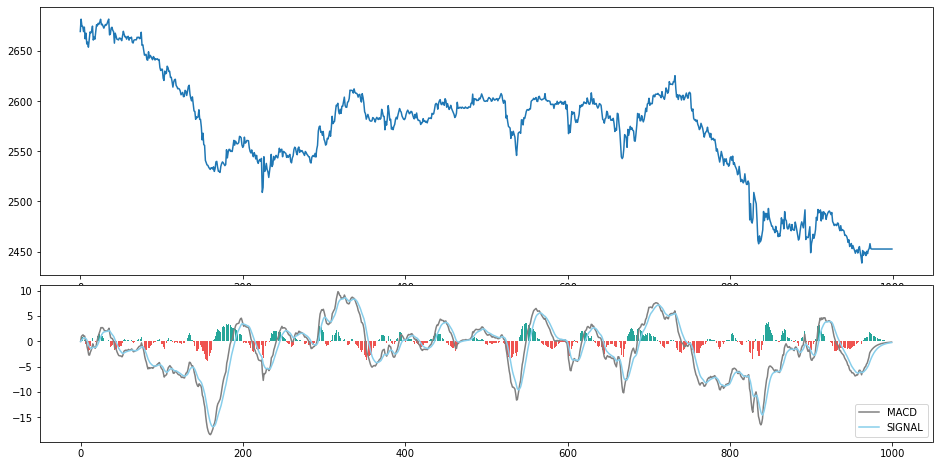

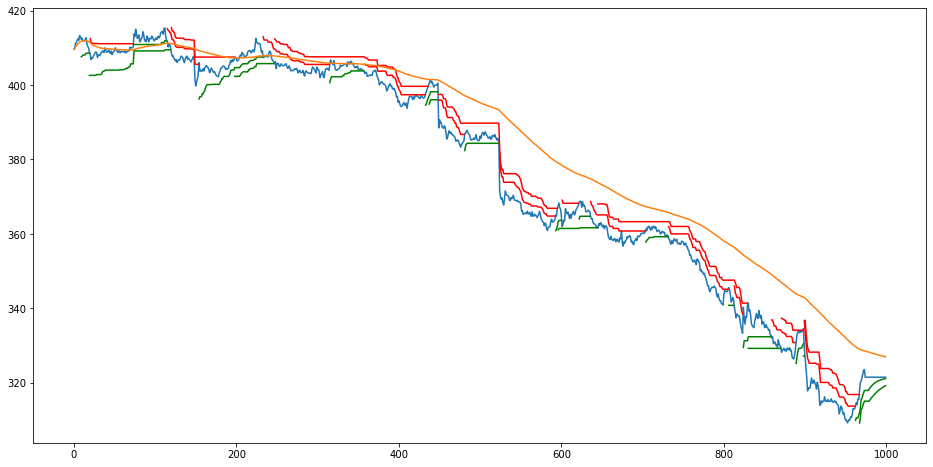

Buy HINDALCO shares at 411.2
Sell HINDALCO at 408.6
Buy HINDALCO shares at 407.55
Sell HINDALCO at 405.7
Buy HINDALCO shares at 400.3
Sell HINDALCO at 388.45
Buy HINDALCO shares at 367.5
Sell HINDALCO at 361.55
Buy HINDALCO shares at 341.45
Sell HINDALCO at 331.45
Buy HINDALCO shares at 334.55
Sell HINDALCO at 326.6
Buy HINDALCO shares at 317.7
Sell HINDALCOat 321.5 
Earning from investing 100k is -50.4 (ROI = -0.05%)
p:l(number)=1:6
success % =14.285714285714285%
Avg win=3.8000000000000114
Avg Loss=-6.699999999999998
HINDUNILVR


					HINDUNILVR


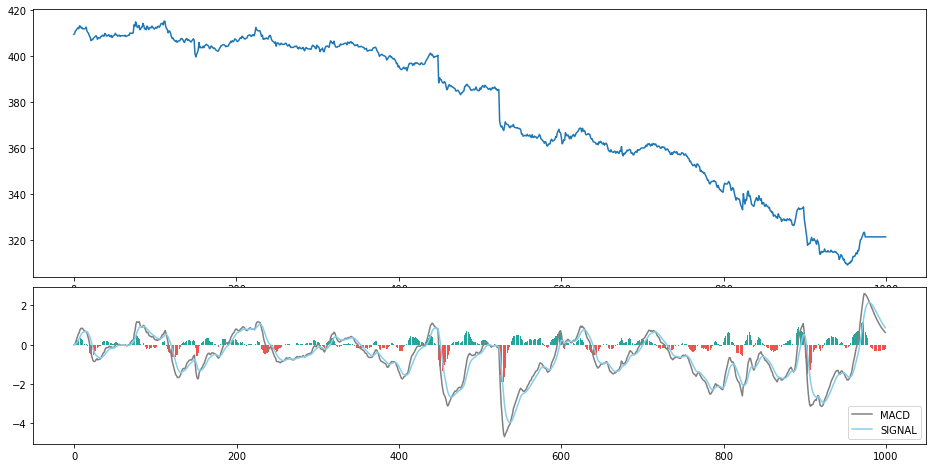

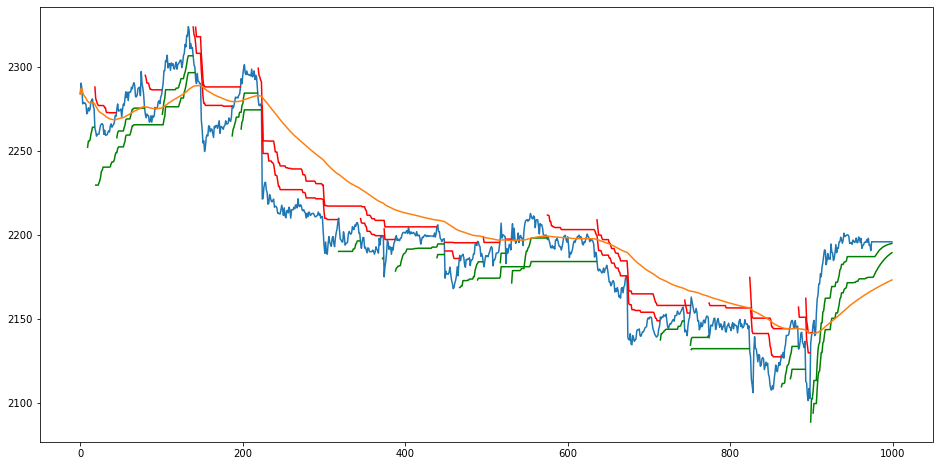

Buy HINDUNILVR shares at 2286.95
Sell HINDUNILVR at 2276.95
Buy HINDUNILVR shares at 2273.05
Sell HINDUNILVR at 2263.05
Buy HINDUNILVR shares at 2274.95
Sell HINDUNILVR at 2264.95
Buy HINDUNILVR shares at 2276.25
Sell HINDUNILVR at 2266.25
Buy HINDUNILVR shares at 2314.0
Sell HINDUNILVR at 2304.0
Buy HINDUNILVR shares at 2293.0
Sell HINDUNILVR at 2283.0
Buy HINDUNILVR shares at 2205.1
Sell HINDUNILVR at 2174.25
Buy HINDUNILVR shares at 2196.15
Sell HINDUNILVR at 2186.15
Buy HINDUNILVR shares at 2198.5
Sell HINDUNILVR at 2188.5
Buy HINDUNILVR shares at 2200.85
Sell HINDUNILVR at 2190.85
Buy HINDUNILVR shares at 2196.55
Sell HINDUNILVR at 2186.55
Buy HINDUNILVR shares at 2206.75
Sell HINDUNILVR at 2196.75
Buy HINDUNILVR shares at 2162.95
Sell HINDUNILVR at 2152.95
Buy HINDUNILVR shares at 2148.95
Sell HINDUNILVR at 2138.95
Buy HINDUNILVR shares at 2145.85
Sell HINDUNILVR at 2135.85
Buy HINDUNILVR shares at 2146.95
Sell HINDUNILVR at 2136.95
Buy HINDUNILVR shares at 2195.9
Sell HINDUNILVR

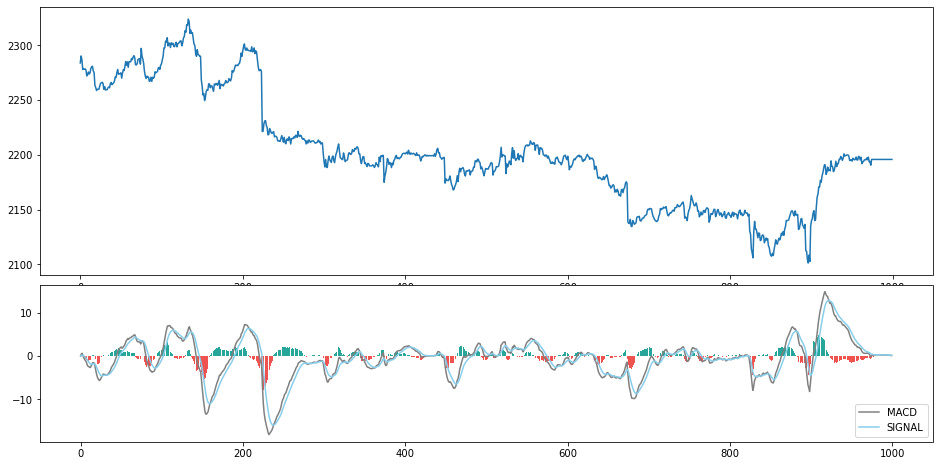

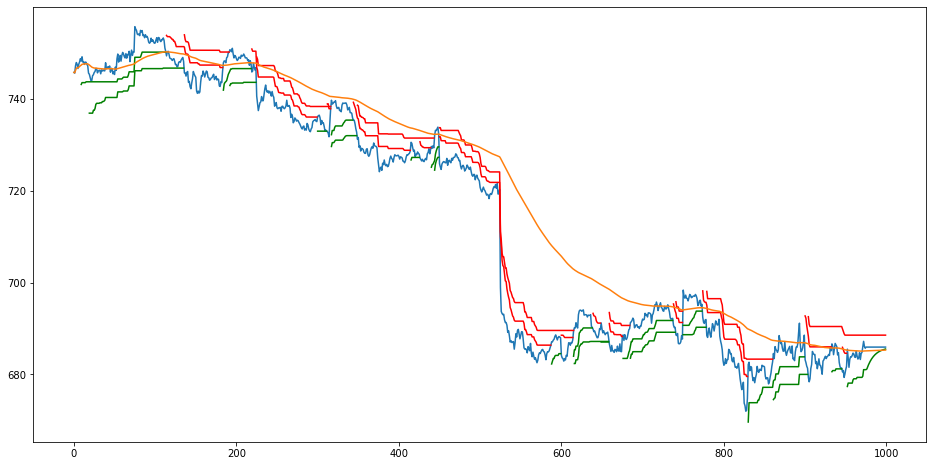

Buy ICICIBANK shares at 747.15
Sell ICICIBANK at 745.6
Buy ICICIBANK shares at 750.65
Sell ICICIBANK at 740.55
Buy ICICIBANK shares at 739.65
Sell ICICIBANK at 731.15
Buy ICICIBANK shares at 732.0
Sell ICICIBANK at 725.85
Buy ICICIBANK shares at 690.15
Sell ICICIBANK at 686.7
Buy ICICIBANK shares at 691.3
Sell ICICIBANK at 688.6
Buy ICICIBANK shares at 698.35
Sell ICICIBANK at 688.45
Buy ICICIBANK shares at 684.55
Sell ICICIBANK at 679.4
Earning from investing 100k is -63.5 (ROI = -0.06%)
p:l(number)=0:8
success % =0.0%
Avg Loss=-5.937499999999972
ITC


					ITC


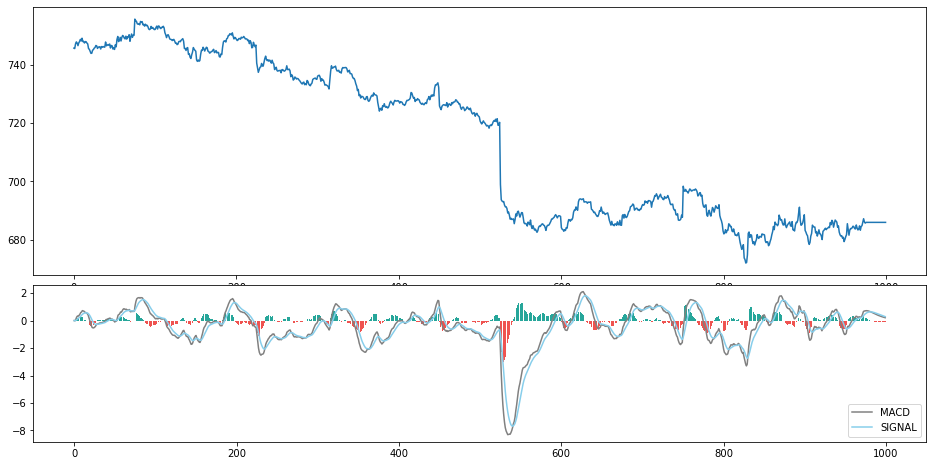

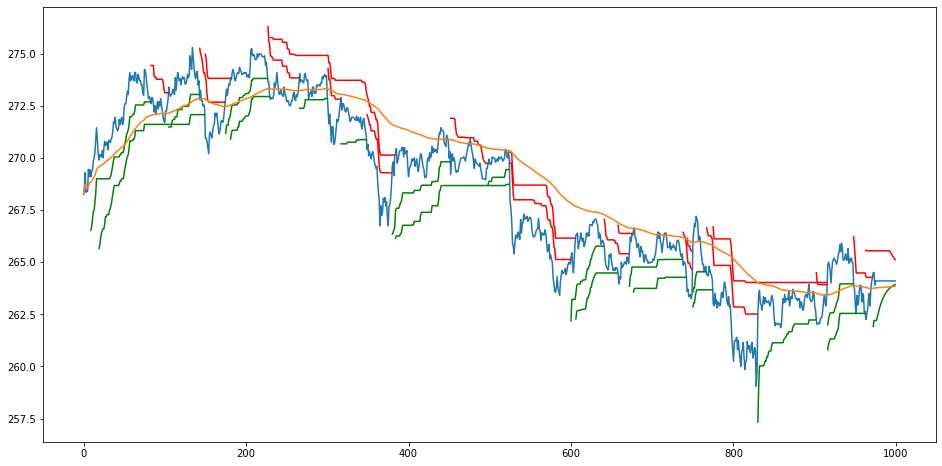

Buy ITC shares at 269.3
Sell ITC at 270.95
Buy ITC shares at 273.85
Sell ITC at 272.8
Buy ITC shares at 270.15
Sell ITC at 267.9
Buy ITC shares at 266.3
Sell ITC at 264.45
Buy ITC shares at 266.55
Sell ITC at 263.6
Buy ITC shares at 265.95
Sell ITC at 263.0
Buy ITC shares at 264.85
Sell ITC at 262.25
Earning from investing 100k is -26.0 (ROI = -0.03%)
p:l(number)=1:6
success % =14.285714285714285%
Avg win=1.6499999999999773
Avg Loss=-2.2750000000000057
INDUSINDBK


					INDUSINDBK


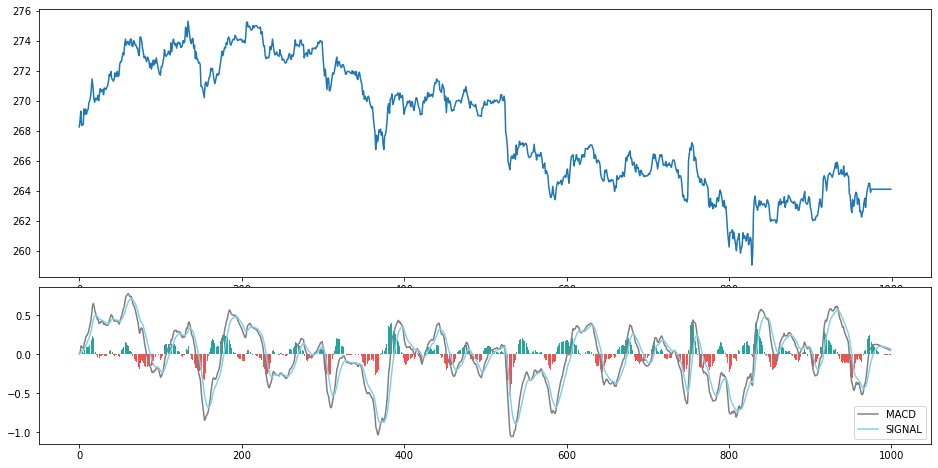

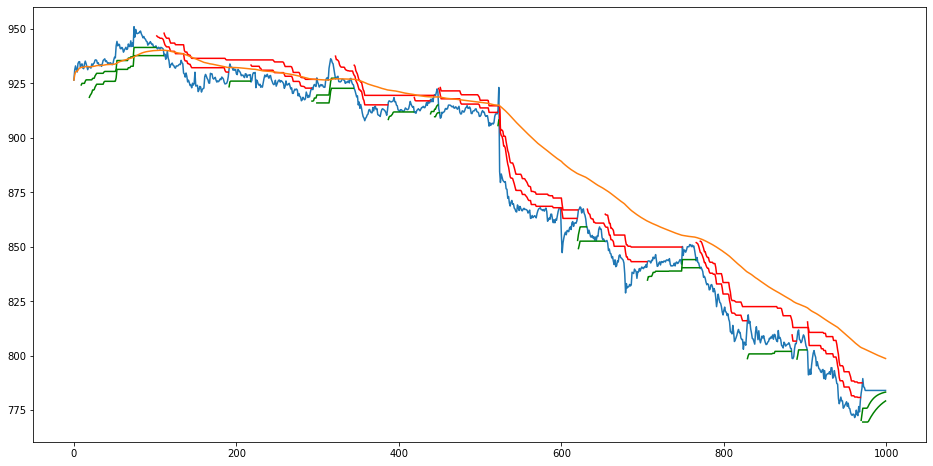

Buy INDUSINDBK shares at 933.0
Sell INDUSINDBK at 923.0
Buy INDUSINDBK shares at 927.5
Sell INDUSINDBK at 917.5
Buy INDUSINDBK shares at 919.8
Sell INDUSINDBK at 909.8
Buy INDUSINDBK shares at 923.1
Sell INDUSINDBK at 884.5
Buy INDUSINDBK shares at 866.95
Sell INDUSINDBK at 856.95
Buy INDUSINDBK shares at 850.1
Sell INDUSINDBK at 840.0
Buy INDUSINDBK shares at 789.5
Sell INDUSINDBKat 784.05 
Earning from investing 100k is -108.15 (ROI = -0.11%)
p:l(number)=1:6
success % =14.285714285714285%
Avg win=-5.4500000000000455
Avg Loss=-14.78333333333334
INFY


					INFY


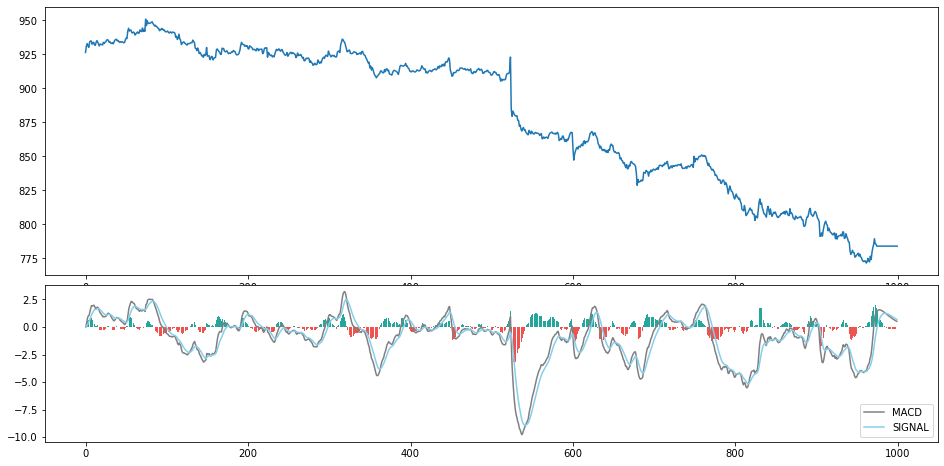

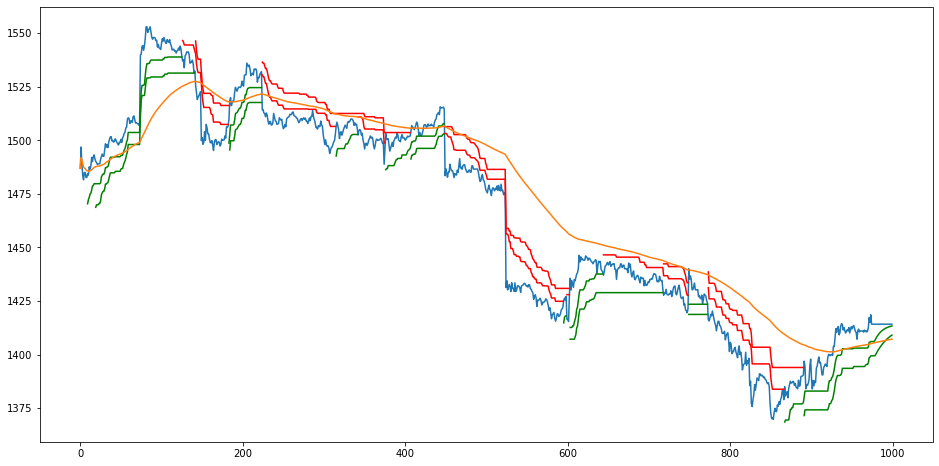

Buy INFY shares at 1488.85
Sell INFY at 1478.85
Buy INFY shares at 1542.35
Sell INFY at 1532.35
Buy INFY shares at 1518.5
Sell INFY at 1514.25
Buy INFY shares at 1504.4
Sell INFY at 1483.45
Buy INFY shares at 1435.55
Sell INFY at 1425.55
Buy INFY shares at 1440.0
Sell INFY at 1430.0
Buy INFY shares at 1427.5
Sell INFY at 1416.35
Buy INFY shares at 1396.9
Sell INFY at 1386.9
Buy INFY shares at 1385.85
Sell INFY at 1375.85
Buy INFY shares at 1387.85
Sell INFYat 1414.15 
Earning from investing 100k is -90.05 (ROI = -0.09%)
p:l(number)=0:10
success % =0.0%
Avg Loss=-7.0049999999999955
JSWSTEEL


					JSWSTEEL


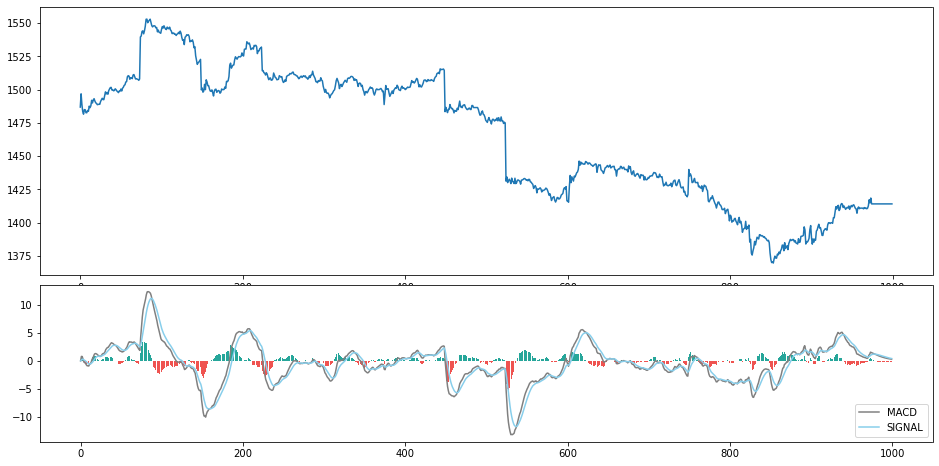

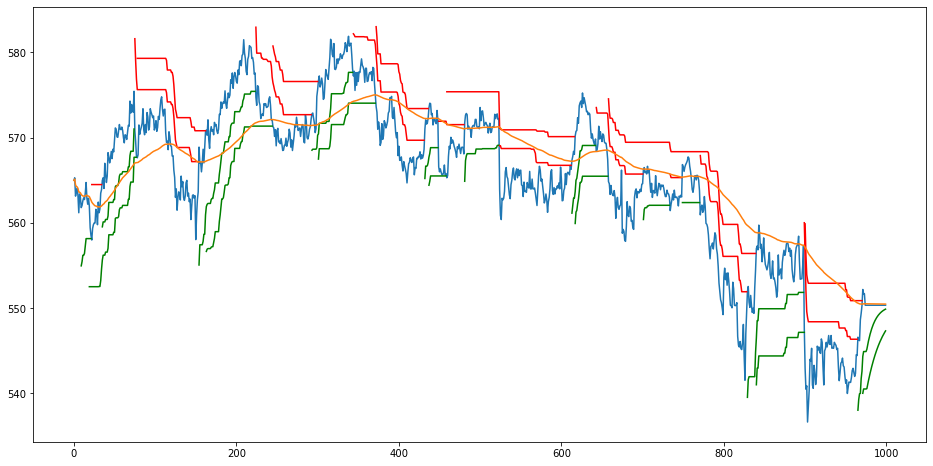

Buy JSWSTEEL shares at 563.15
Sell JSWSTEEL at 567.65
Buy JSWSTEEL shares at 570.9
Sell JSWSTEEL at 571.3
Buy JSWSTEEL shares at 576.7
Sell JSWSTEEL at 573.65
Buy JSWSTEEL shares at 573.5
Sell JSWSTEEL at 565.3
Buy JSWSTEEL shares at 570.2
Sell JSWSTEEL at 564.85
Buy JSWSTEEL shares at 557.0
Sell JSWSTEEL at 547.0
Buy JSWSTEEL shares at 552.2
Sell JSWSTEELat 550.35 
Earning from investing 100k is -37.55 (ROI = -0.04%)
p:l(number)=2:5
success % =28.57142857142857%
Avg win=2.4499999999999886
Avg Loss=-5.6900000000000315
KOTAKBANK


					KOTAKBANK


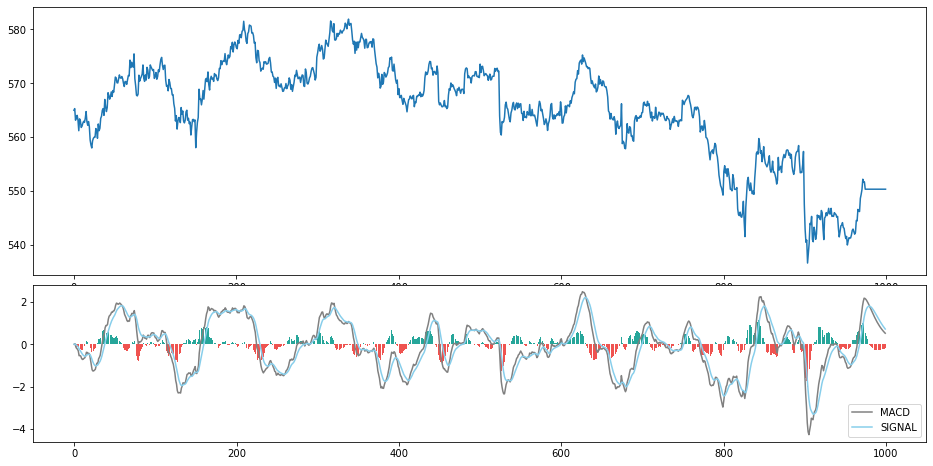

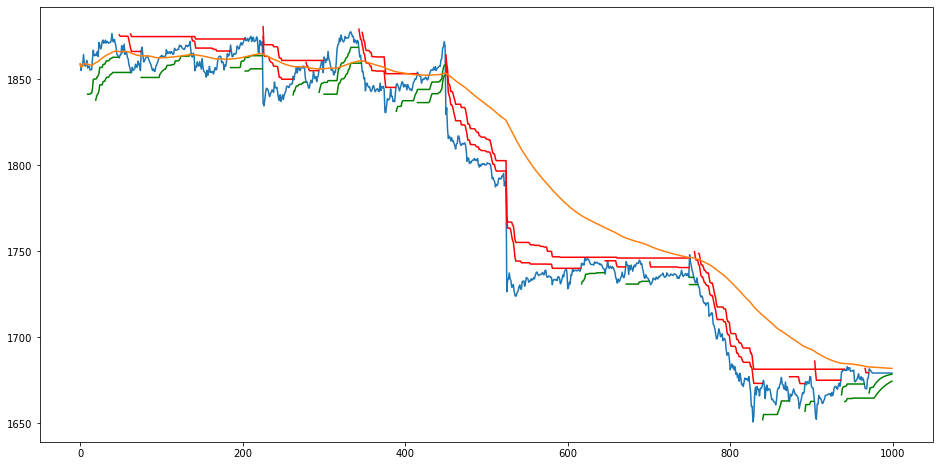

Buy KOTAKBANK shares at 1858.3
Sell KOTAKBANK at 1848.3
Buy KOTAKBANK shares at 1864.1
Sell KOTAKBANK at 1854.1
Buy KOTAKBANK shares at 1874.35
Sell KOTAKBANK at 1836.4
Buy KOTAKBANK shares at 1863.0
Sell KOTAKBANK at 1853.0
Buy KOTAKBANK shares at 1856.15
Sell KOTAKBANK at 1846.15
Buy KOTAKBANK shares at 1854.2
Sell KOTAKBANK at 1829.65
Buy KOTAKBANK shares at 1748.0
Sell KOTAKBANK at 1738.0
Buy KOTAKBANK shares at 1735.05
Sell KOTAKBANK at 1729.45
Buy KOTAKBANK shares at 1681.5
Sell KOTAKBANK at 1671.5
Buy KOTAKBANK shares at 1681.65
Sell KOTAKBANKat 1679.2 
Earning from investing 100k is -150.55 (ROI = -0.15%)
p:l(number)=0:10
success % =0.0%
Avg Loss=-13.054999999999973
LT


					LT


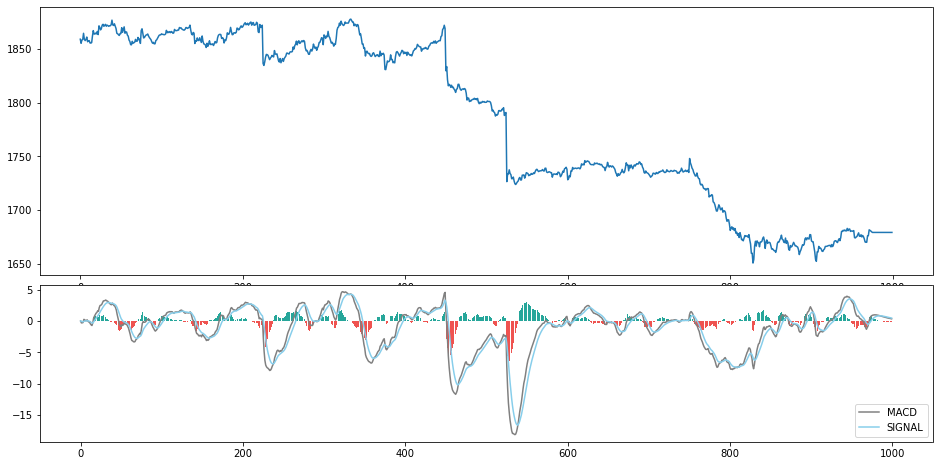

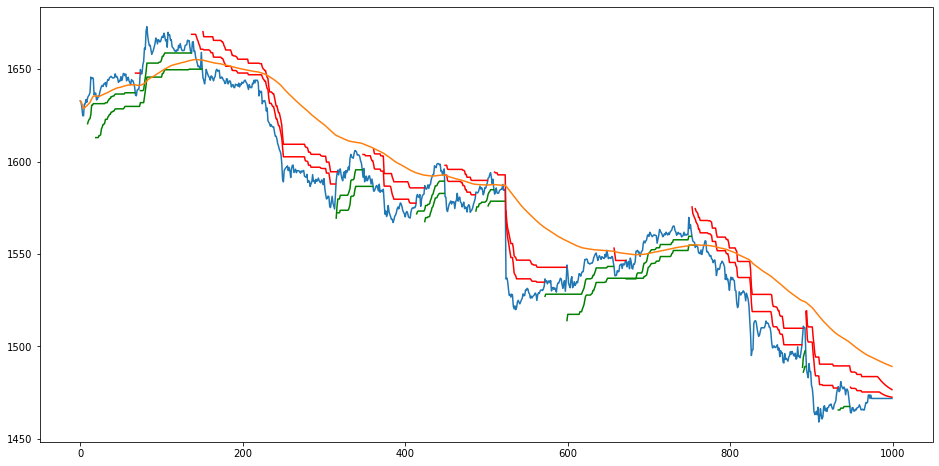

Buy LT shares at 1629.1
Sell LT at 1619.1
Buy LT shares at 1633.7
Sell LT at 1623.7
Buy LT shares at 1649.75
Sell LT at 1639.75
Buy LT shares at 1662.9
Sell LT at 1652.9
Buy LT shares at 1660.5
Sell LT at 1650.5
Buy LT shares at 1595.35
Sell LT at 1585.35
Buy LT shares at 1586.95
Sell LT at 1580.95
Buy LT shares at 1591.0
Sell LT at 1581.0
Buy LT shares at 1544.0
Sell LT at 1534.0
Buy LT shares at 1531.7
Sell LT at 1521.7
Buy LT shares at 1546.65
Sell LT at 1536.65
Buy LT shares at 1510.9
Sell LT at 1500.9
Earning from investing 100k is -140.0 (ROI = -0.14%)
p:l(number)=0:12
success % =0.0%
Avg Loss=-9.666666666666666
M&M


					M&M


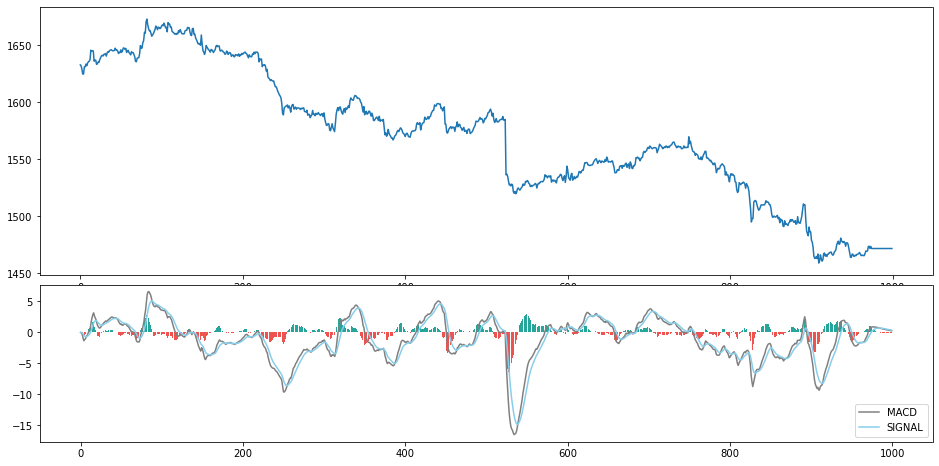

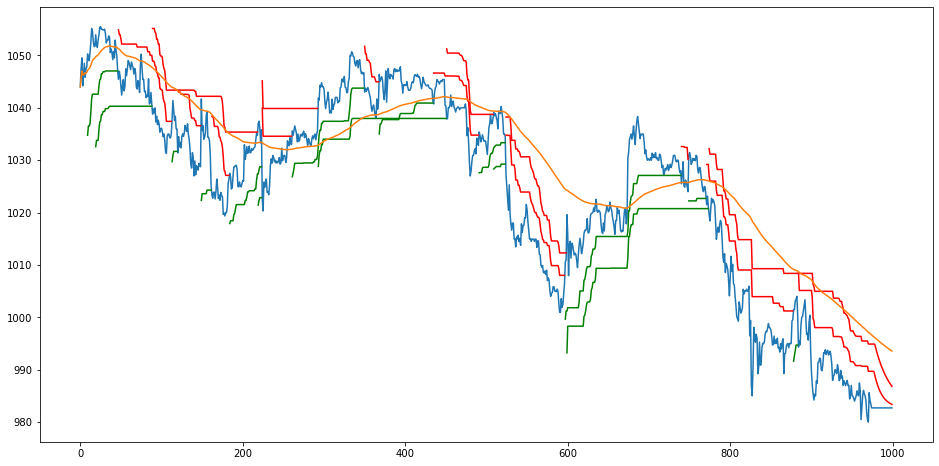

Buy M&M shares at 1049.55
Sell M&M at 1039.55
Buy M&M shares at 1037.0
Sell M&M at 1022.55
Buy M&M shares at 1041.85
Sell M&M at 1031.85
Buy M&M shares at 1046.4
Sell M&M at 1037.85
Buy M&M shares at 1039.1
Sell M&M at 1027.2
Buy M&M shares at 1019.6
Sell M&M at 1009.6
Buy M&M shares at 1013.95
Sell M&M at 1003.95
Buy M&M shares at 1027.6
Sell M&M at 1017.6
Earning from investing 100k is -100.9 (ROI = -0.1%)
p:l(number)=0:8
success % =0.0%
Avg Loss=-10.612500000000011
MARUTI


					MARUTI


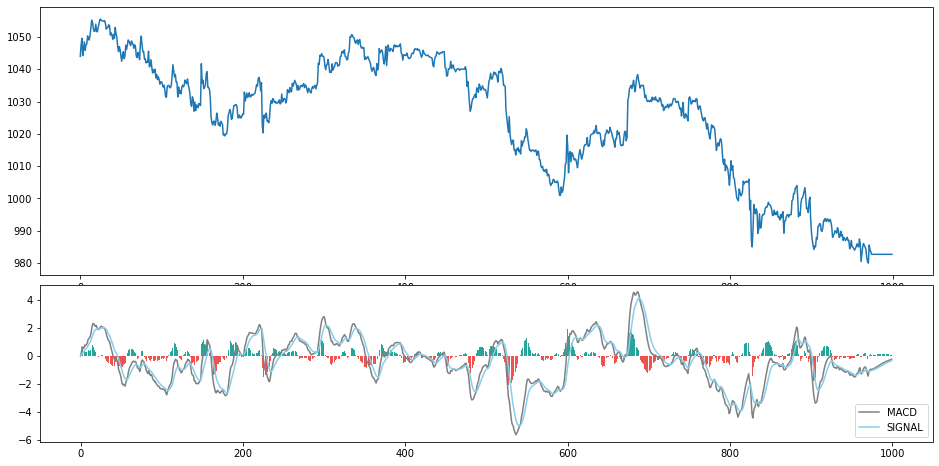

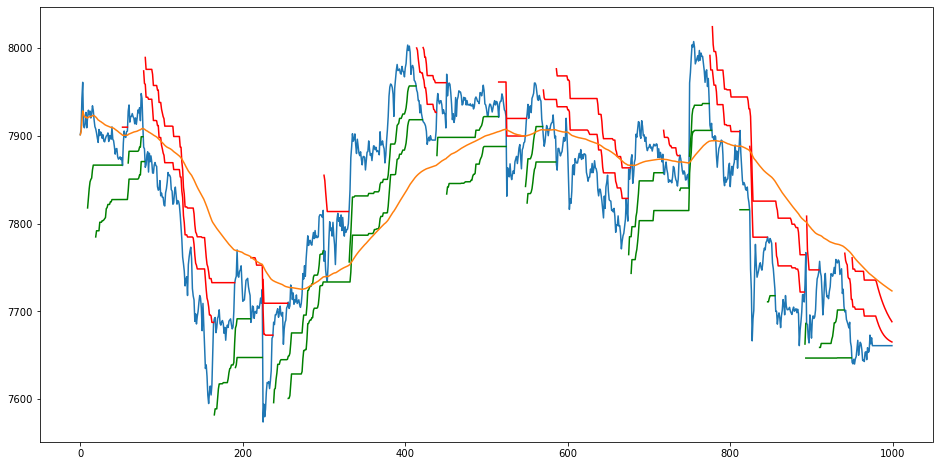

Buy MARUTI shares at 7942.45
Sell MARUTI at 7932.45
Buy MARUTI shares at 7909.0
Sell MARUTI at 7899.0
Buy MARUTI shares at 7921.05
Sell MARUTI at 7911.05
Buy MARUTI shares at 7910.25
Sell MARUTI at 7900.25
Buy MARUTI shares at 7892.35
Sell MARUTI at 7882.35
Buy MARUTI shares at 7901.0
Sell MARUTI at 7891.0
Buy MARUTI shares at 7894.3
Sell MARUTI at 7884.3
Buy MARUTI shares at 7885.0
Sell MARUTI at 7875.0
Buy MARUTI shares at 7874.25
Sell MARUTI at 7864.25
Buy MARUTI shares at 7921.85
Sell MARUTI at 7911.85
Buy MARUTI shares at 7920.25
Sell MARUTI at 7910.25
Buy MARUTI shares at 7948.0
Sell MARUTI at 7938.0
Buy MARUTI shares at 7737.0
Sell MARUTI at 7727.0
Buy MARUTI shares at 7738.9
Sell MARUTI at 7728.9
Buy MARUTI shares at 7711.45
Sell MARUTI at 7701.45
Buy MARUTI shares at 7718.15
Sell MARUTI at 7708.15
Buy MARUTI shares at 7710.5
Sell MARUTI at 7700.5
Buy MARUTI shares at 7721.0
Sell MARUTI at 7711.0
Buy MARUTI shares at 7713.05
Sell MARUTI at 7703.05
Buy MARUTI shares at 7704.55
S

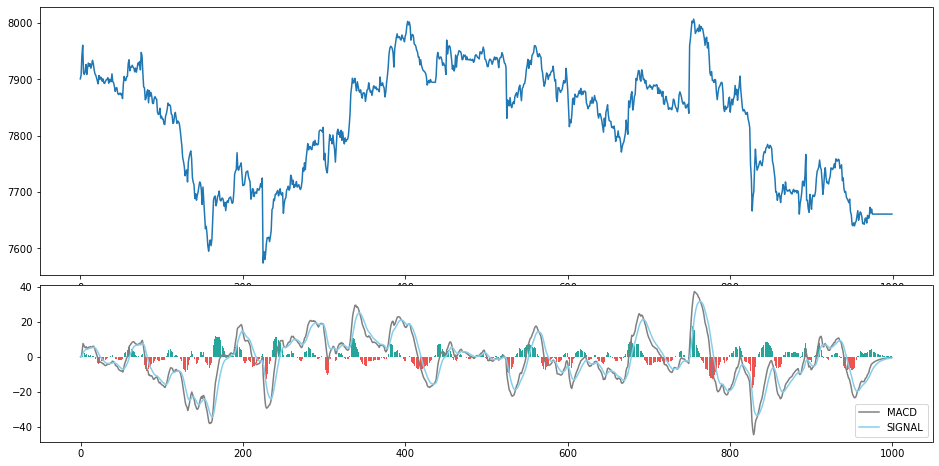

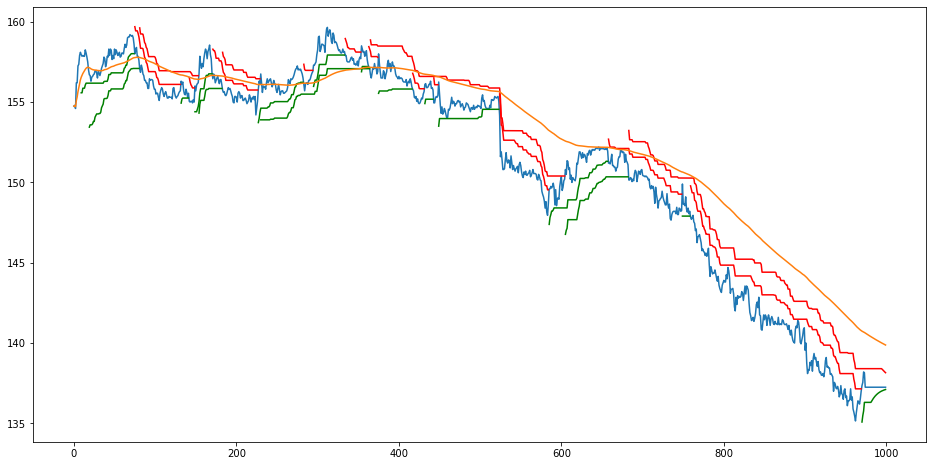

Buy NTPC shares at 154.6
Sell NTPC at 157.05
Buy NTPC shares at 156.75
Sell NTPC at 155.75
Buy NTPC shares at 156.75
Sell NTPC at 156.7
Buy NTPC shares at 150.8
Sell NTPC at 150.15
Earning from investing 100k is -7.25 (ROI = -0.01%)
p:l(number)=1:3
success % =25.0%
Avg win=2.450000000000017
Avg Loss=-0.5666666666666723
NESTLEIND


					NESTLEIND


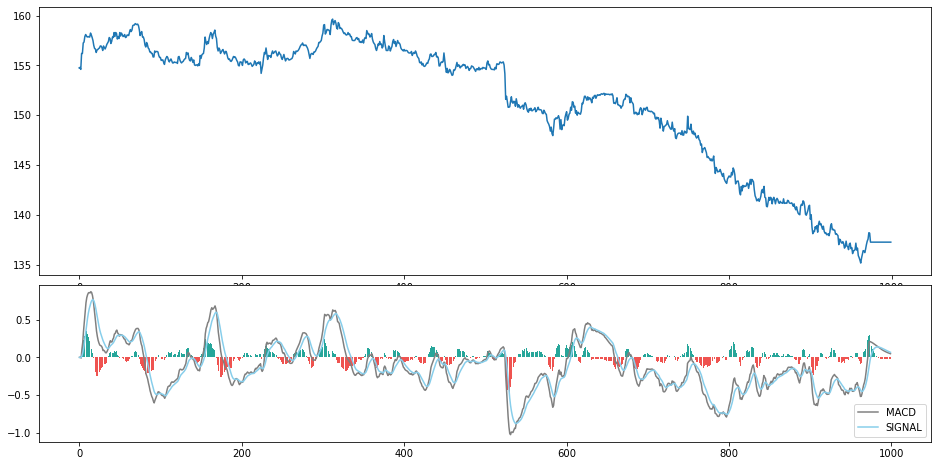

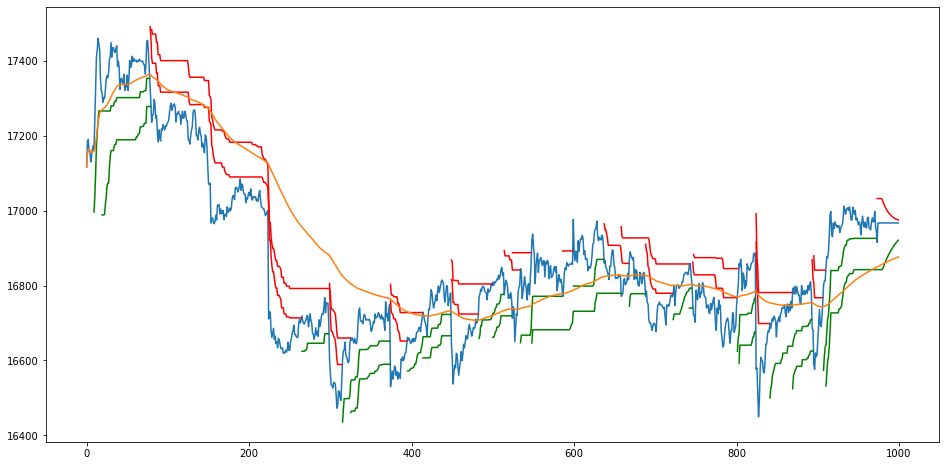

Buy NESTLEIND shares at 17189.95
Sell NESTLEIND at 17179.95
Buy NESTLEIND shares at 17159.6
Sell NESTLEIND at 17149.6
Buy NESTLEIND shares at 17144.1
Sell NESTLEIND at 17134.1
Buy NESTLEIND shares at 17237.65
Sell NESTLEIND at 17227.65
Buy NESTLEIND shares at 17429.7
Sell NESTLEIND at 17419.7
Buy NESTLEIND shares at 17320.55
Sell NESTLEIND at 17310.55
Buy NESTLEIND shares at 17302.1
Sell NESTLEIND at 17292.1
Buy NESTLEIND shares at 17434.95
Sell NESTLEIND at 17424.95
Buy NESTLEIND shares at 17422.3
Sell NESTLEIND at 17412.3
Buy NESTLEIND shares at 17400.0
Sell NESTLEIND at 17390.0
Buy NESTLEIND shares at 17323.5
Sell NESTLEIND at 17313.5
Buy NESTLEIND shares at 17339.35
Sell NESTLEIND at 17329.35
Buy NESTLEIND shares at 17337.4
Sell NESTLEIND at 17327.4
Buy NESTLEIND shares at 17351.2
Sell NESTLEIND at 17341.2
Buy NESTLEIND shares at 17386.6
Sell NESTLEIND at 17376.6
Buy NESTLEIND shares at 17406.4
Sell NESTLEIND at 17396.4
Buy NESTLEIND shares at 17400.0
Sell NESTLEIND at 17390.0
Buy 

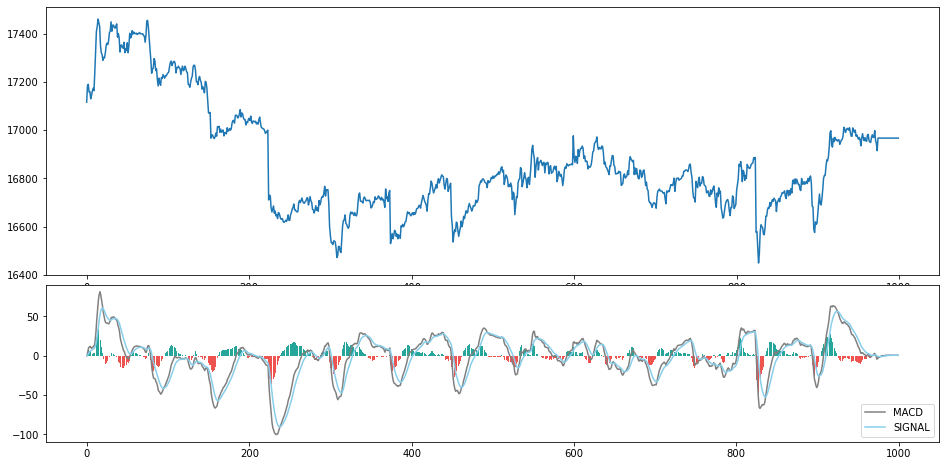

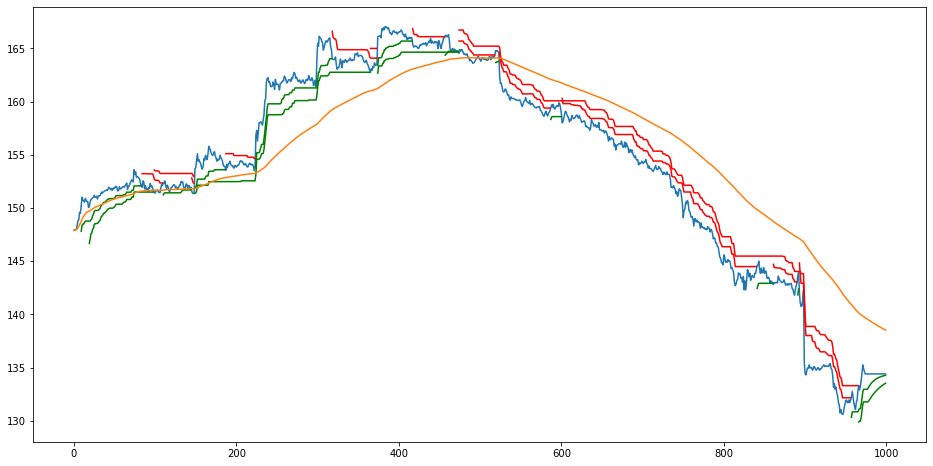

Buy ONGC shares at 147.95
Sell ONGC at 151.45
Buy ONGC shares at 153.7
Sell ONGC at 162.75
Buy ONGC shares at 166.1
Sell ONGC at 164.55
Buy ONGC shares at 133.3
Sell ONGCat 134.4 
Earning from investing 100k is 4.1 (ROI = 0.0%)
p:l(number)=3:1
success % =75.0%
Avg win=4.550000000000002
Avg Loss=-1.549999999999983
POWERGRID


					POWERGRID


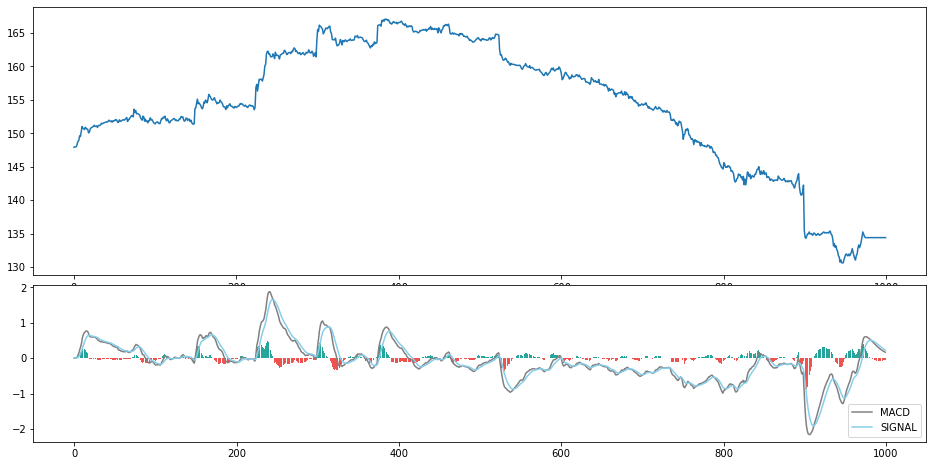

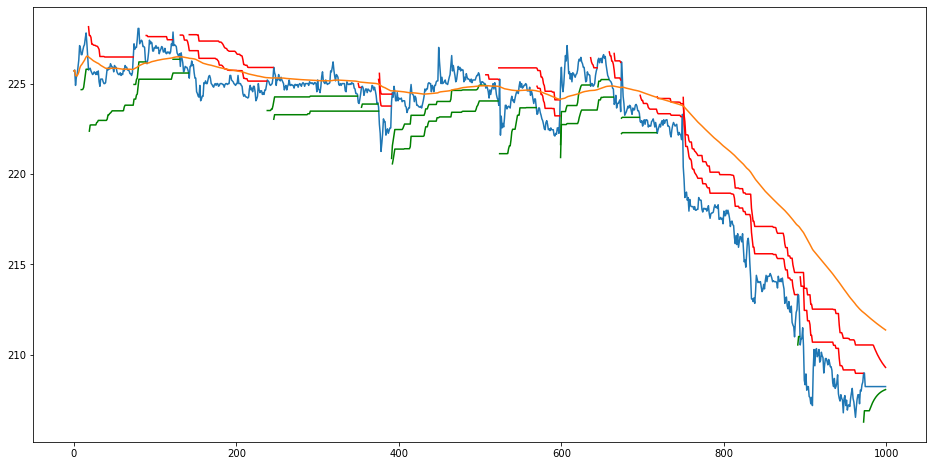

Buy POWERGRID shares at 224.9
Sell POWERGRID at 225.3
Buy POWERGRID shares at 225.9
Sell POWERGRID at 222.75
Buy POWERGRID shares at 224.5
Sell POWERGRID at 223.8
Buy POWERGRID shares at 225.1
Sell POWERGRID at 223.85
Buy POWERGRID shares at 226.2
Sell POWERGRID at 222.25
Earning from investing 100k is -18.65 (ROI = -0.02%)
p:l(number)=1:4
success % =20.0%
Avg win=0.4000000000000057
Avg Loss=-2.2624999999999957
RELIANCE


					RELIANCE


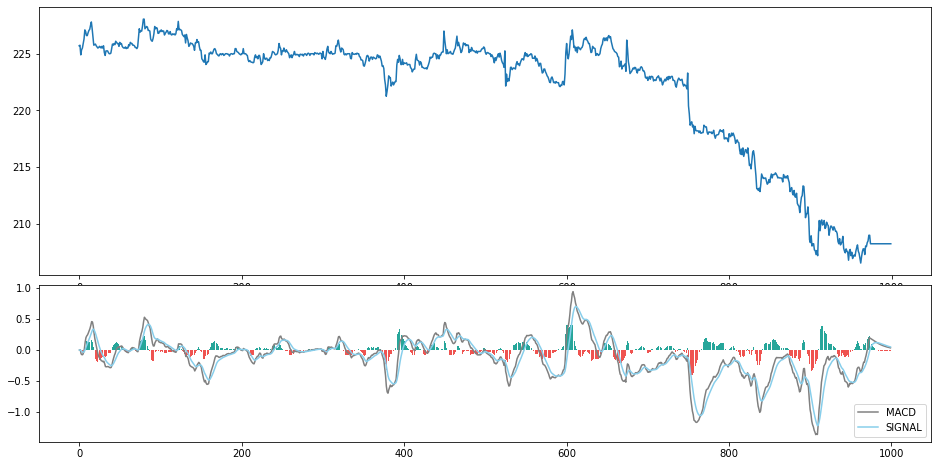

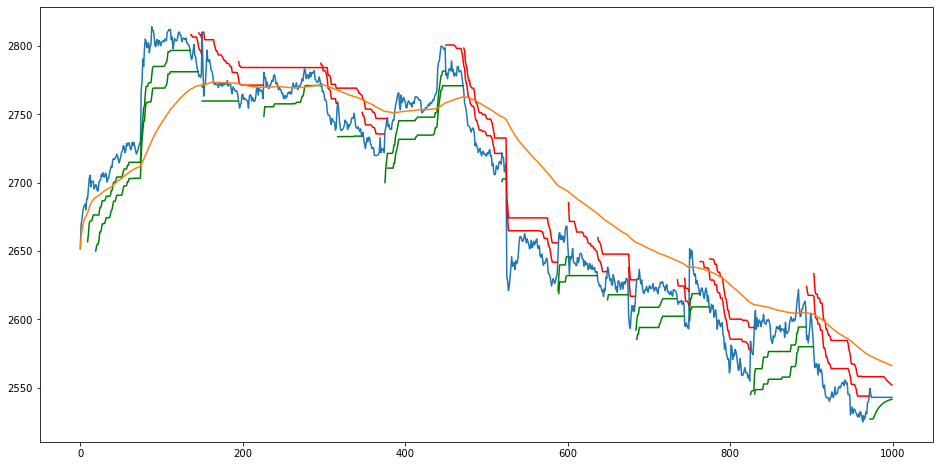

Buy RELIANCE shares at 2673.1
Sell RELIANCE at 2663.1
Buy RELIANCE shares at 2696.7
Sell RELIANCE at 2686.7
Buy RELIANCE shares at 2799.5
Sell RELIANCE at 2789.5
Buy RELIANCE shares at 2800.85
Sell RELIANCE at 2790.85
Buy RELIANCE shares at 2797.45
Sell RELIANCE at 2787.45
Buy RELIANCE shares at 2810.2
Sell RELIANCE at 2800.2
Buy RELIANCE shares at 2747.45
Sell RELIANCE at 2737.45
Buy RELIANCE shares at 2764.0
Sell RELIANCE at 2754.0
Buy RELIANCE shares at 2751.0
Sell RELIANCE at 2741.0
Buy RELIANCE shares at 2661.75
Sell RELIANCE at 2651.75
Buy RELIANCE shares at 2629.5
Sell RELIANCE at 2619.5
Buy RELIANCE shares at 2628.9
Sell RELIANCE at 2618.9
Buy RELIANCE shares at 2623.4
Sell RELIANCE at 2613.4
Buy RELIANCE shares at 2621.6
Sell RELIANCE at 2611.6
Buy RELIANCE shares at 2651.65
Sell RELIANCE at 2641.65
Buy RELIANCE shares at 2633.6
Sell RELIANCE at 2623.6
Buy RELIANCE shares at 2619.85
Sell RELIANCE at 2609.85
Buy RELIANCE shares at 2599.0
Sell RELIANCE at 2589.0
Buy RELIANCE sha

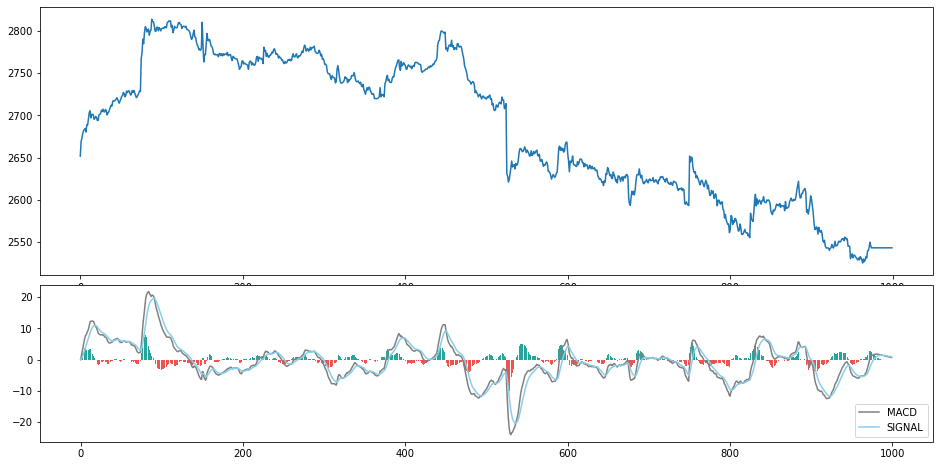

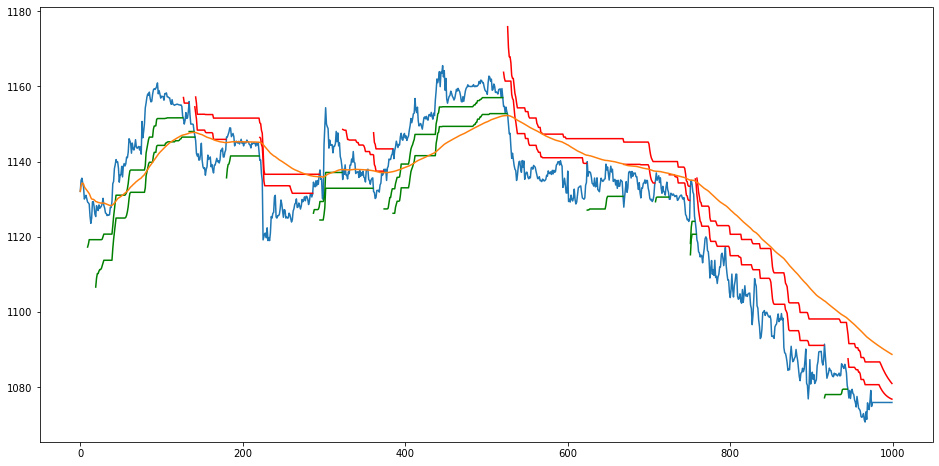

Buy SBILIFE shares at 1135.6
Sell SBILIFE at 1125.6
Buy SBILIFE shares at 1123.6
Sell SBILIFE at 1113.6
Buy SBILIFE shares at 1156.0
Sell SBILIFE at 1145.6
Buy SBILIFE shares at 1137.8
Sell SBILIFE at 1127.8
Buy SBILIFE shares at 1145.75
Sell SBILIFE at 1135.75
Buy SBILIFE shares at 1143.45
Sell SBILIFE at 1133.45
Buy SBILIFE shares at 1133.75
Sell SBILIFE at 1123.75
Earning from investing 100k is -84.4 (ROI = -0.08%)
p:l(number)=0:7
success % =0.0%
Avg Loss=-10.05714285714287
SBIN


					SBIN


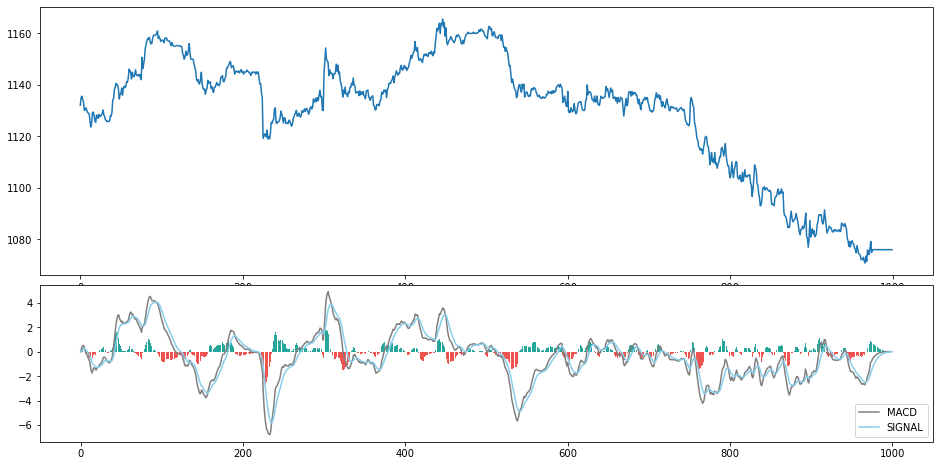

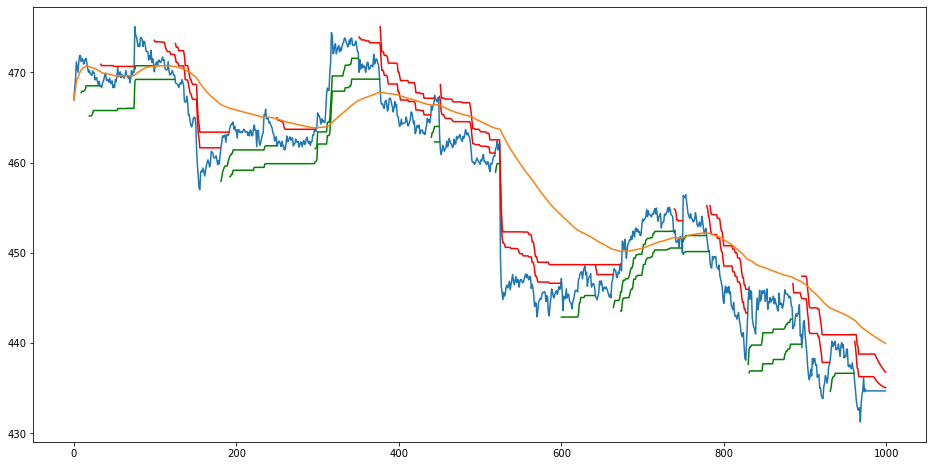

Buy SBIN shares at 469.25
Sell SBIN at 468.85
Buy SBIN shares at 463.85
Sell SBIN at 468.05
Buy SBIN shares at 467.45
Sell SBIN at 461.5
Buy SBIN shares at 448.8
Sell SBIN at 450.0
Buy SBIN shares at 456.35
Sell SBIN at 448.85
Buy SBIN shares at 446.25
Sell SBIN at 439.5
Earning from investing 100k is -27.2 (ROI = -0.03%)
p:l(number)=2:4
success % =33.33333333333333%
Avg win=2.6999999999999886
Avg Loss=-5.1499999999999915
SHREECEM


					SHREECEM


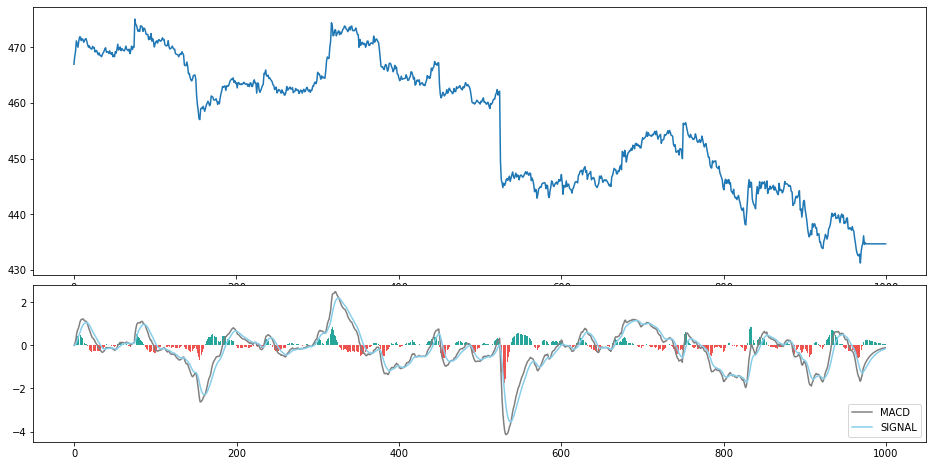

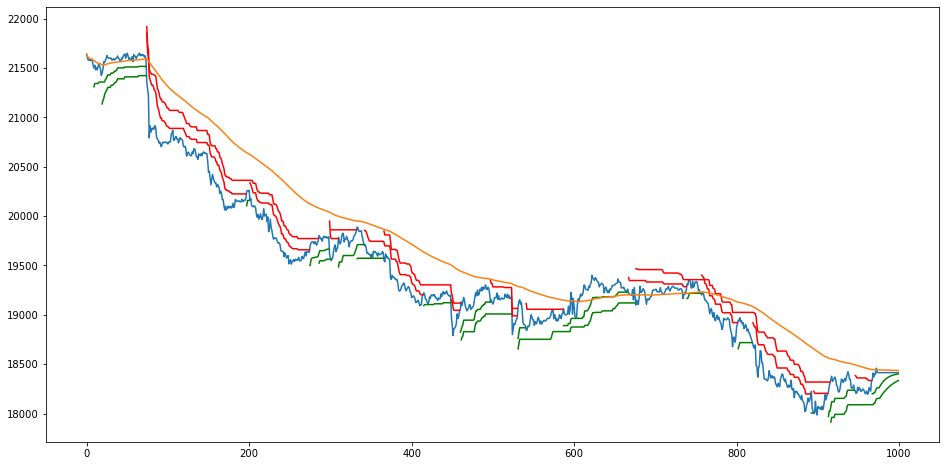

Buy SHREECEM shares at 21578.6
Sell SHREECEM at 21568.6
Buy SHREECEM shares at 21527.05
Sell SHREECEM at 21517.05
Buy SHREECEM shares at 21527.1
Sell SHREECEM at 21517.1
Buy SHREECEM shares at 21501.0
Sell SHREECEM at 21491.0
Buy SHREECEM shares at 21511.55
Sell SHREECEM at 21501.55
Buy SHREECEM shares at 21489.0
Sell SHREECEM at 21479.0
Buy SHREECEM shares at 21445.25
Sell SHREECEM at 21435.25
Buy SHREECEM shares at 21597.9
Sell SHREECEM at 21587.9
Buy SHREECEM shares at 21580.0
Sell SHREECEM at 21570.0
Buy SHREECEM shares at 21583.0
Sell SHREECEM at 21573.0
Buy SHREECEM shares at 21590.5
Sell SHREECEM at 21580.5
Buy SHREECEM shares at 21568.65
Sell SHREECEM at 21558.65
Buy SHREECEM shares at 21629.75
Sell SHREECEM at 21619.75
Buy SHREECEM shares at 21589.2
Sell SHREECEM at 21579.2
Buy SHREECEM shares at 21576.85
Sell SHREECEM at 21566.85
Buy SHREECEM shares at 21634.75
Sell SHREECEM at 21624.75
Buy SHREECEM shares at 21613.4
Sell SHREECEM at 21603.4
Buy SHREECEM shares at 21612.35
Se

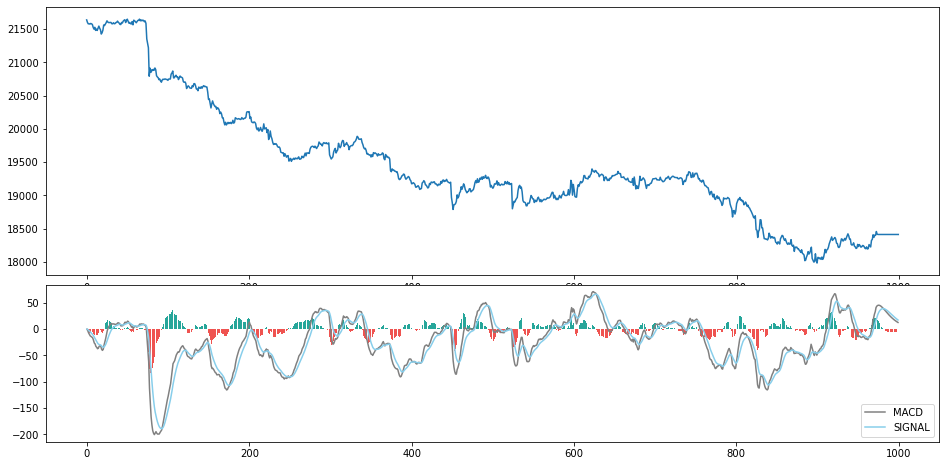

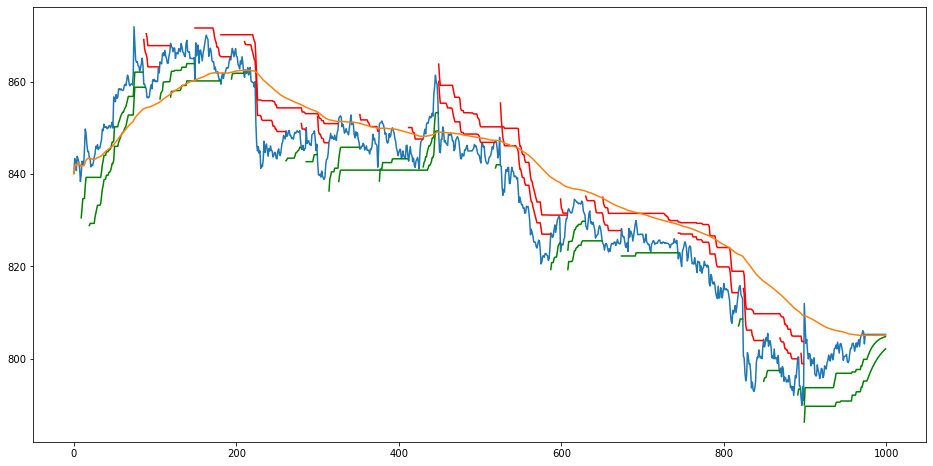

Buy SUNPHARMA shares at 842.9
Sell SUNPHARMA at 832.9
Buy SUNPHARMA shares at 868.3
Sell SUNPHARMA at 859.45
Buy SUNPHARMA shares at 852.0
Sell SUNPHARMA at 842.0
Buy SUNPHARMA shares at 850.85
Sell SUNPHARMA at 840.85
Buy SUNPHARMA shares at 847.6
Sell SUNPHARMA at 849.0
Buy SUNPHARMA shares at 832.15
Sell SUNPHARMA at 824.95
Buy SUNPHARMA shares at 812.0
Sell SUNPHARMA at 802.0
Buy SUNPHARMA shares at 800.0
Sell SUNPHARMAat 805.3 
Earning from investing 100k is -65.35 (ROI = -0.07%)
p:l(number)=2:6
success % =25.0%
Avg win=3.349999999999966
Avg Loss=-9.34166666666664
TATAMOTORS


					TATAMOTORS


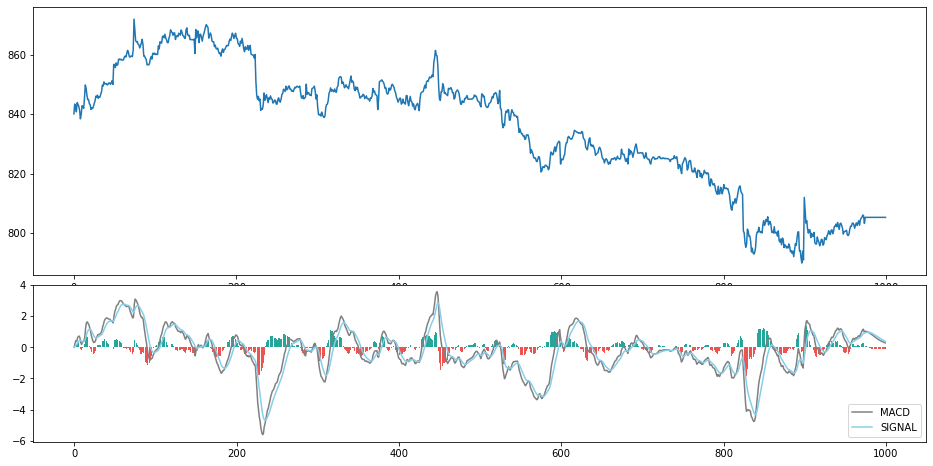

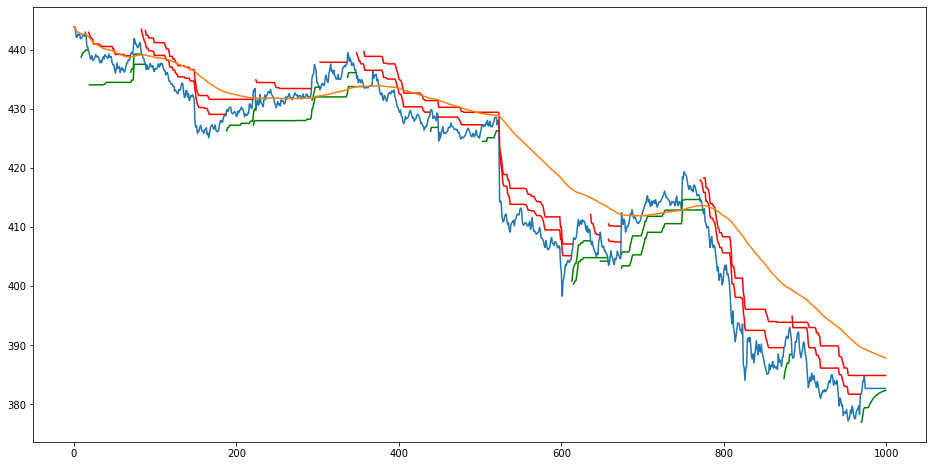

Buy TATAMOTORS shares at 443.2
Sell TATAMOTORS at 437.5
Buy TATAMOTORS shares at 433.15
Sell TATAMOTORS at 433.6
Buy TATAMOTORS shares at 408.15
Sell TATAMOTORS at 403.55
Buy TATAMOTORS shares at 412.45
Sell TATAMOTORS at 412.25
Earning from investing 100k is -18.05 (ROI = -0.02%)
p:l(number)=1:3
success % =25.0%
Avg win=0.4500000000000455
Avg Loss=-3.499999999999981
TATACONSUM


					TATACONSUM


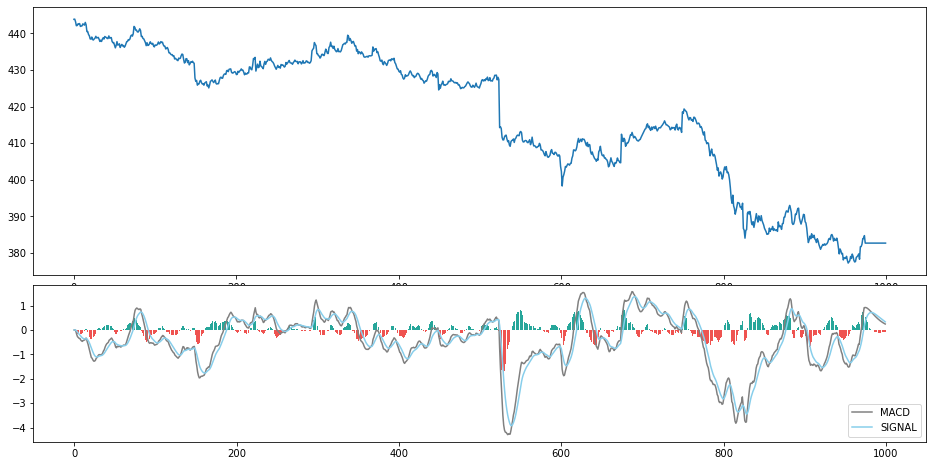

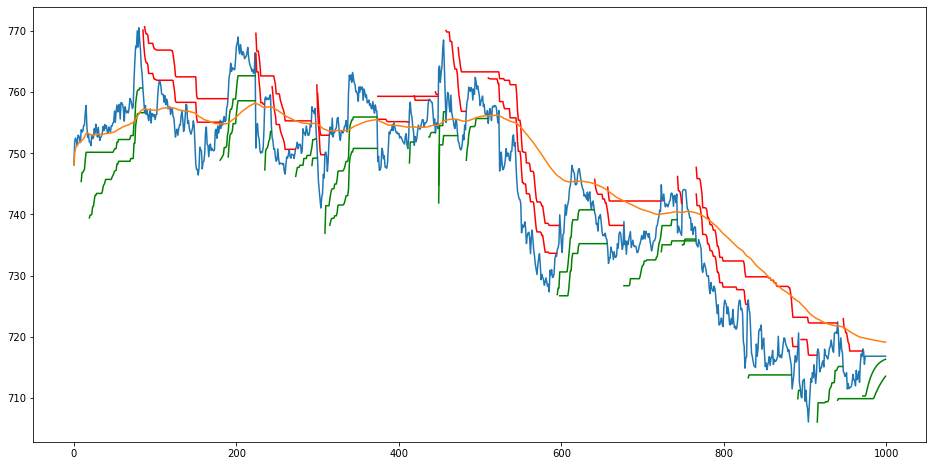

Buy TATACONSUM shares at 752.5
Sell TATACONSUM at 742.5
Buy TATACONSUM shares at 759.85
Sell TATACONSUM at 750.85
Buy TATACONSUM shares at 757.6
Sell TATACONSUM at 748.7
Buy TATACONSUM shares at 754.25
Sell TATACONSUM at 748.65
Buy TATACONSUM shares at 763.8
Sell TATACONSUM at 753.8
Buy TATACONSUM shares at 739.95
Sell TATACONSUM at 729.95
Buy TATACONSUM shares at 744.85
Sell TATACONSUM at 735.25
Buy TATACONSUM shares at 722.45
Sell TATACONSUM at 712.45
Buy TATACONSUM shares at 718.05
Sell TATACONSUMat 716.85 
Earning from investing 100k is -92.3 (ROI = -0.09%)
p:l(number)=0:9
success % =0.0%
Avg Loss=-8.255555555555551
TATASTEEL


					TATASTEEL


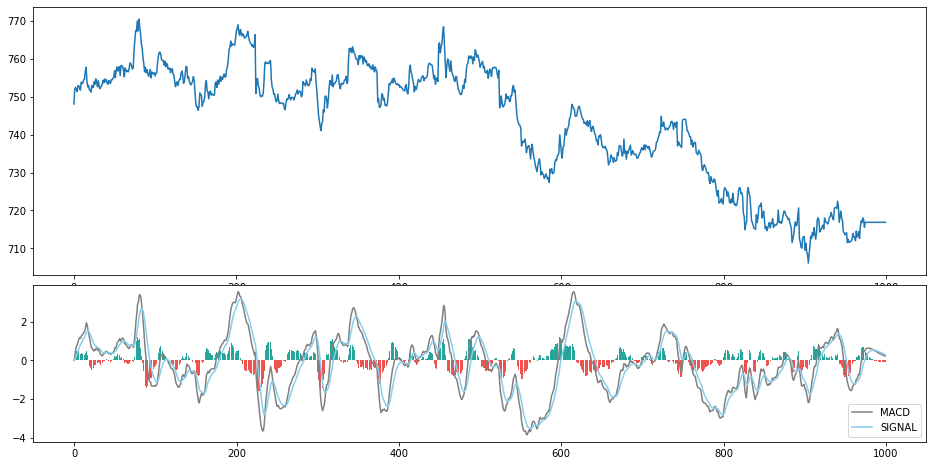

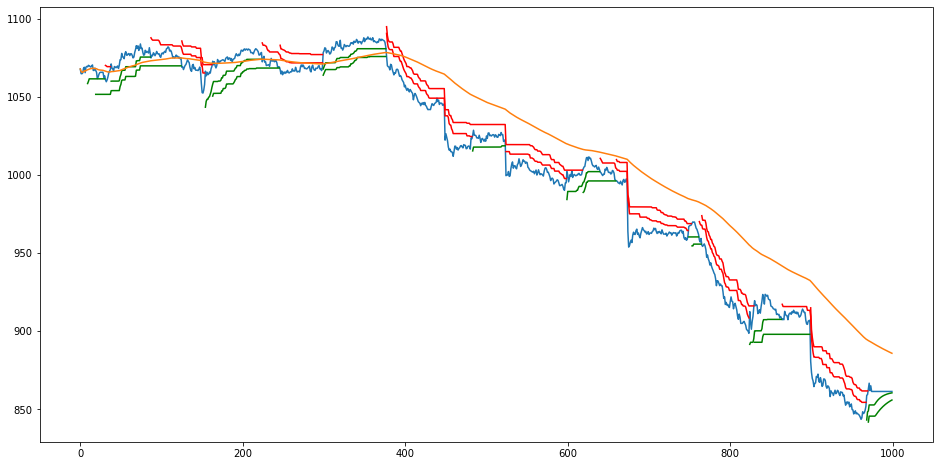

Buy TATASTEEL shares at 1064.85
Sell TATASTEEL at 1054.85
Buy TATASTEEL shares at 1071.15
Sell TATASTEEL at 1069.0
Buy TATASTEEL shares at 1072.9
Sell TATASTEEL at 1062.9
Buy TATASTEEL shares at 1078.45
Sell TATASTEEL at 1075.8
Buy TATASTEEL shares at 1003.9
Sell TATASTEEL at 993.9
Buy TATASTEEL shares at 969.1
Sell TATASTEEL at 959.1
Buy TATASTEEL shares at 919.55
Sell TATASTEEL at 909.55
Buy TATASTEEL shares at 911.0
Sell TATASTEEL at 880.75
Buy TATASTEEL shares at 862.95
Sell TATASTEELat 861.4 
Earning from investing 100k is -104.6 (ROI = -0.1%)
p:l(number)=1:8
success % =11.11111111111111%
Avg win=-1.5500000000000682
Avg Loss=-10.631250000000023
TCS


					TCS


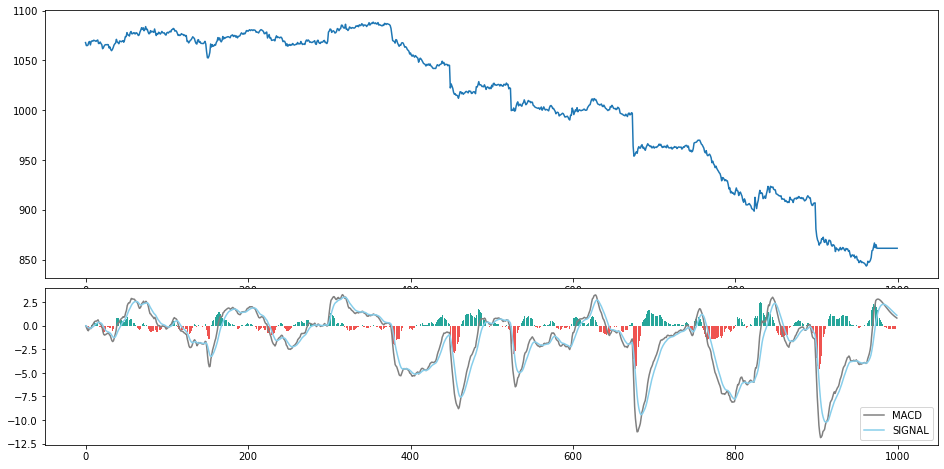

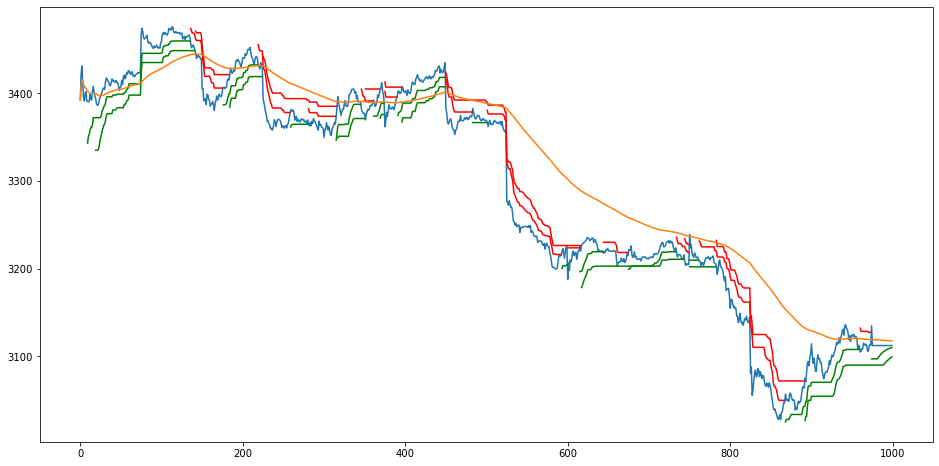

Buy TCS shares at 3431.3
Sell TCS at 3421.3
Buy TCS shares at 3394.45
Sell TCS at 3384.45
Buy TCS shares at 3390.9
Sell TCS at 3380.9
Buy TCS shares at 3393.7
Sell TCS at 3383.7
Buy TCS shares at 3406.9
Sell TCS at 3396.9
Buy TCS shares at 3461.95
Sell TCS at 3451.95
Buy TCS shares at 3452.4
Sell TCS at 3442.4
Buy TCS shares at 3463.45
Sell TCS at 3453.45
Buy TCS shares at 3421.95
Sell TCS at 3411.95
Buy TCS shares at 3440.0
Sell TCS at 3430.0
Buy TCS shares at 3396.25
Sell TCS at 3386.25
Buy TCS shares at 3380.0
Sell TCS at 3370.0
Buy TCS shares at 3397.4
Sell TCS at 3387.4
Buy TCS shares at 3405.5
Sell TCS at 3395.5
Buy TCS shares at 3390.4
Sell TCS at 3361.85
Buy TCS shares at 3407.65
Sell TCS at 3381.85
Buy TCS shares at 3227.0
Sell TCS at 3217.0
Buy TCS shares at 3221.85
Sell TCS at 3211.85
Buy TCS shares at 3221.75
Sell TCS at 3211.75
Buy TCS shares at 3213.5
Sell TCS at 3203.5
Buy TCS shares at 3211.8
Sell TCS at 3201.8
Buy TCS shares at 3221.5
Sell TCS at 3211.5
Buy TCS shares 

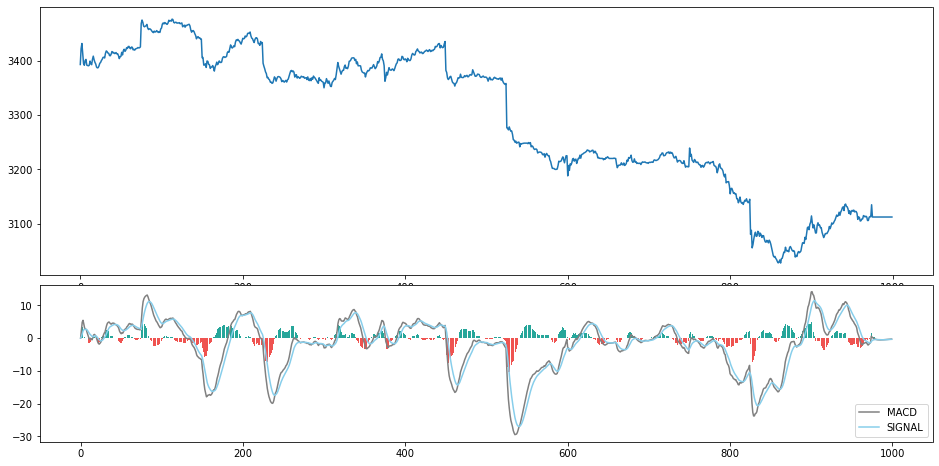

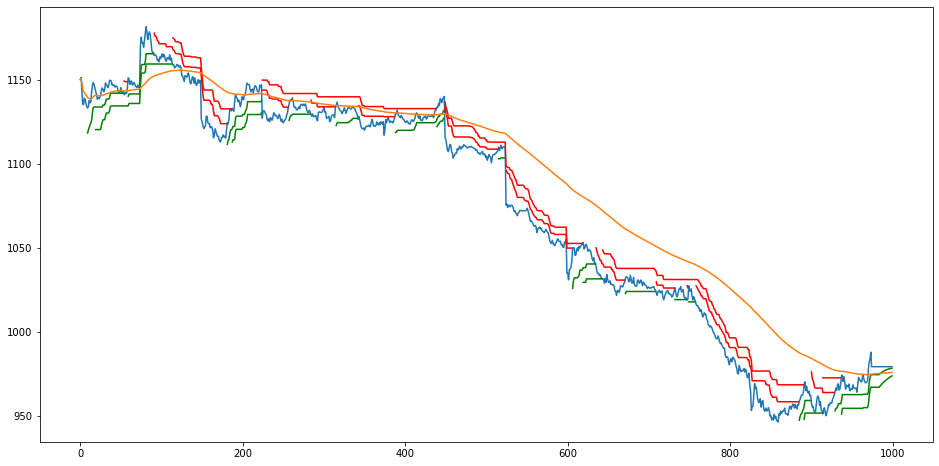

Buy TECHM shares at 1143.5
Sell TECHM at 1133.5
Buy TECHM shares at 1134.0
Sell TECHM at 1124.0
Buy TECHM shares at 1165.45
Sell TECHM at 1158.75
Buy TECHM shares at 1133.0
Sell TECHM at 1127.1
Buy TECHM shares at 1133.7
Sell TECHM at 1115.6
Buy TECHM shares at 1053.2
Sell TECHM at 1043.2
Buy TECHM shares at 1044.15
Sell TECHM at 1034.15
Buy TECHM shares at 969.15
Sell TECHM at 959.15
Buy TECHM shares at 973.65
Sell TECHM at 963.65
Buy TECHM shares at 969.1
Sell TECHMat 979.35 
Earning from investing 100k is -100.45 (ROI = -0.1%)
p:l(number)=0:10
success % =0.0%
Avg Loss=-8.045000000000027
TITAN


					TITAN


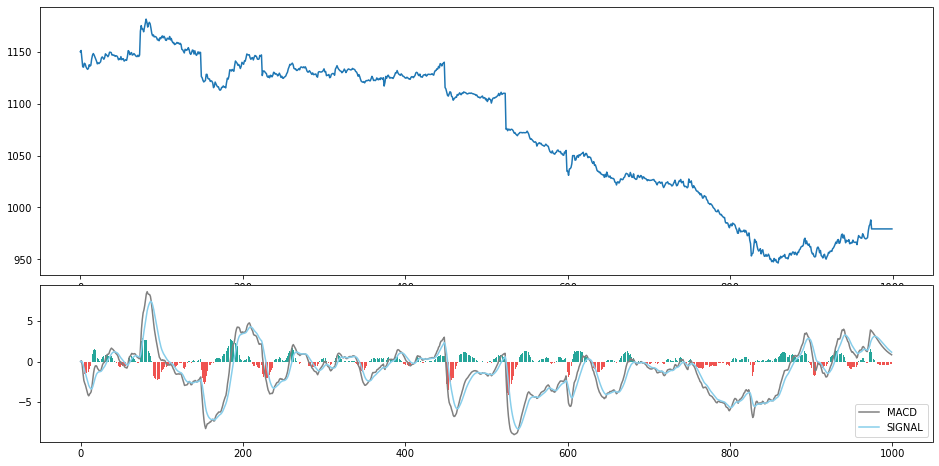

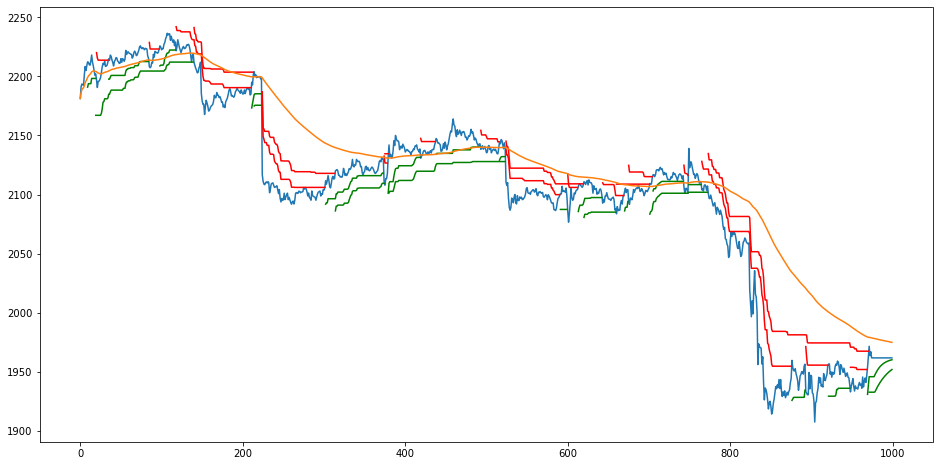

Buy TITAN shares at 2193.55
Sell TITAN at 2183.55
Buy TITAN shares at 2200.9
Sell TITAN at 2190.9
Buy TITAN shares at 2214.9
Sell TITAN at 2204.9
Buy TITAN shares at 2225.85
Sell TITAN at 2215.85
Buy TITAN shares at 2229.15
Sell TITAN at 2219.15
Buy TITAN shares at 2203.95
Sell TITAN at 2116.75
Buy TITAN shares at 2120.0
Sell TITAN at 2110.0
Buy TITAN shares at 2116.55
Sell TITAN at 2106.55
Buy TITAN shares at 2141.95
Sell TITAN at 2131.95
Buy TITAN shares at 2131.45
Sell TITAN at 2121.45
Buy TITAN shares at 2140.55
Sell TITAN at 2130.55
Buy TITAN shares at 2147.4
Sell TITAN at 2137.4
Buy TITAN shares at 2136.9
Sell TITAN at 2126.9
Buy TITAN shares at 2149.0
Sell TITAN at 2139.0
Buy TITAN shares at 2142.5
Sell TITAN at 2110.45
Buy TITAN shares at 2110.85
Sell TITAN at 2100.85
Buy TITAN shares at 2107.4
Sell TITAN at 2097.4
Buy TITAN shares at 2116.7
Sell TITAN at 2106.7
Buy TITAN shares at 2112.7
Sell TITAN at 2102.7
Buy TITAN shares at 2139.0
Sell TITAN at 2129.0
Buy TITAN shares at 2

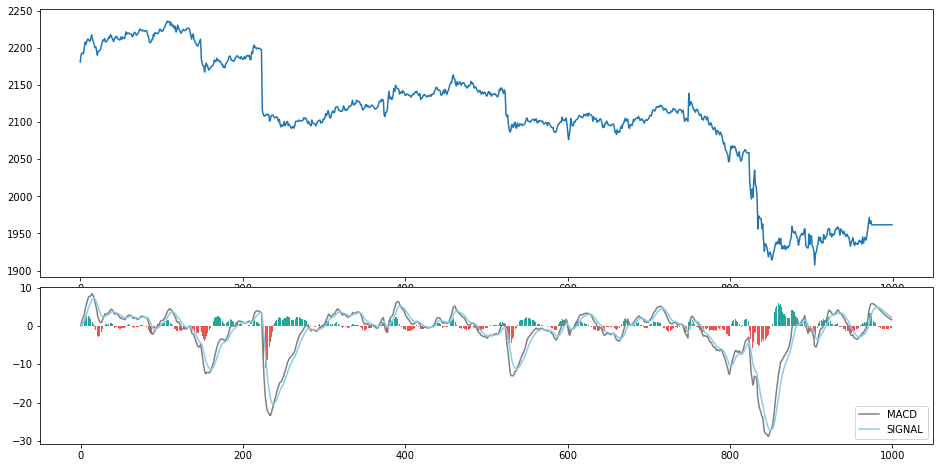

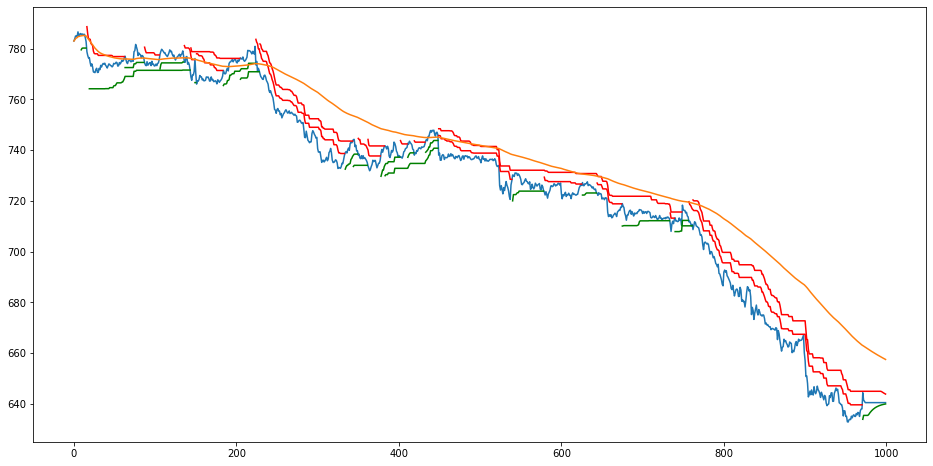

Buy UPL shares at 784.95
Sell UPL at 774.95
Buy UPL shares at 777.0
Sell UPL at 767.0
Buy UPL shares at 776.35
Sell UPL at 770.1
Buy UPL shares at 744.15
Sell UPL at 733.75
Buy UPL shares at 741.7
Sell UPL at 738.0
Buy UPL shares at 718.3
Sell UPL at 708.65
Earning from investing 100k is -62.0 (ROI = -0.06%)
p:l(number)=0:6
success % =0.0%
Avg Loss=-8.333333333333334
WIPRO


					WIPRO


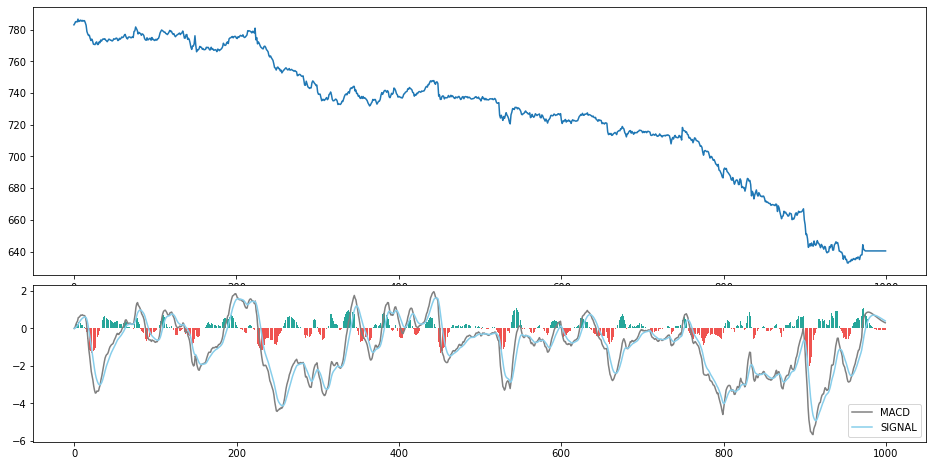

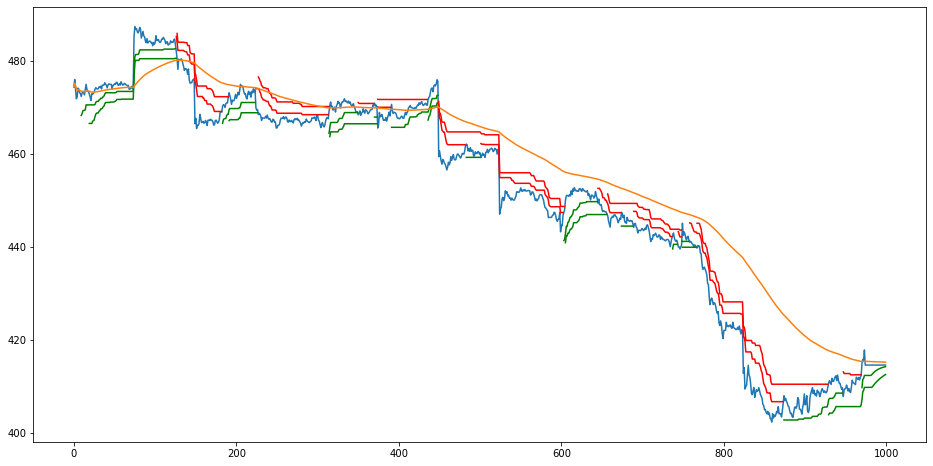

Buy WIPRO shares at 473.9
Sell WIPRO at 480.55
Buy WIPRO shares at 473.2
Sell WIPRO at 468.5
Buy WIPRO shares at 470.45
Sell WIPRO at 465.6
Buy WIPRO shares at 471.8
Sell WIPRO at 459.45
Buy WIPRO shares at 450.1
Sell WIPRO at 446.8
Buy WIPRO shares at 445.15
Sell WIPRO at 439.8
Buy WIPRO shares at 410.8
Sell WIPROat 414.65 
Earning from investing 100k is -34.05 (ROI = -0.03%)
p:l(number)=2:5
success % =28.57142857142857%
Avg win=5.25
Avg Loss=-6.1099999999999905
ULTRACEMCO


					ULTRACEMCO


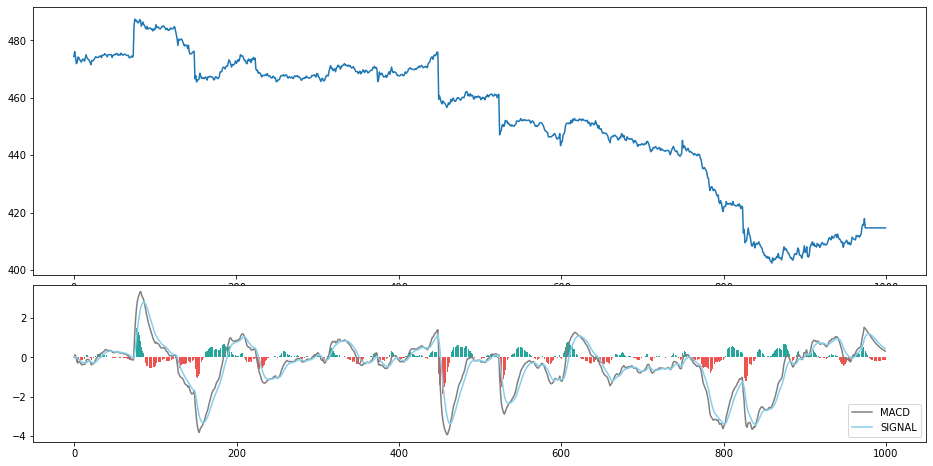

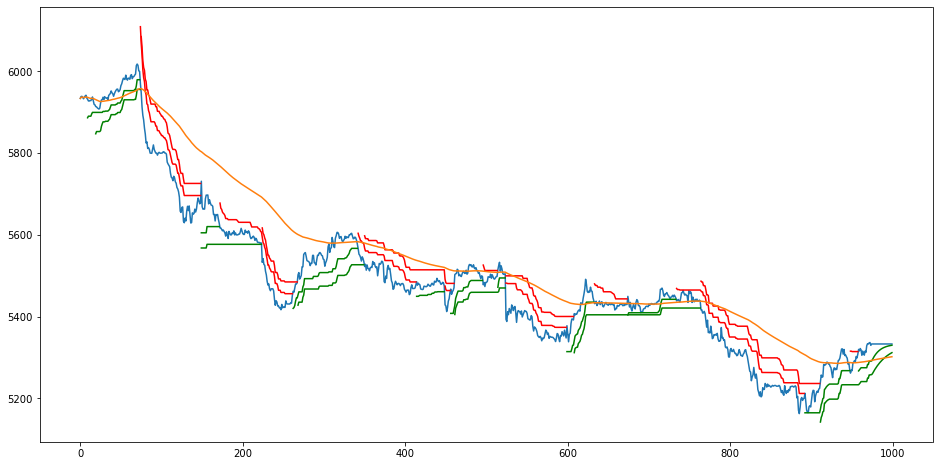

Buy ULTRACEMCO shares at 5938.75
Sell ULTRACEMCO at 5928.75
Buy ULTRACEMCO shares at 5927.35
Sell ULTRACEMCO at 5917.35
Buy ULTRACEMCO shares at 5918.0
Sell ULTRACEMCO at 5908.0
Buy ULTRACEMCO shares at 5910.0
Sell ULTRACEMCO at 5900.0
Buy ULTRACEMCO shares at 5945.4
Sell ULTRACEMCO at 5935.4
Buy ULTRACEMCO shares at 5983.25
Sell ULTRACEMCO at 5973.25
Buy ULTRACEMCO shares at 6000.1
Sell ULTRACEMCO at 5990.1
Buy ULTRACEMCO shares at 5731.25
Sell ULTRACEMCO at 5721.25
Buy ULTRACEMCO shares at 5662.95
Sell ULTRACEMCO at 5652.95
Buy ULTRACEMCO shares at 5686.0
Sell ULTRACEMCO at 5676.0
Buy ULTRACEMCO shares at 5672.45
Sell ULTRACEMCO at 5662.45
Buy ULTRACEMCO shares at 5650.0
Sell ULTRACEMCO at 5640.0
Buy ULTRACEMCO shares at 5649.85
Sell ULTRACEMCO at 5639.85
Buy ULTRACEMCO shares at 5628.9
Sell ULTRACEMCO at 5618.9
Buy ULTRACEMCO shares at 5502.2
Sell ULTRACEMCO at 5492.2
Buy ULTRACEMCO shares at 5495.5
Sell ULTRACEMCO at 5485.5
Buy ULTRACEMCO shares at 5536.0
Sell ULTRACEMCO at 5526.0


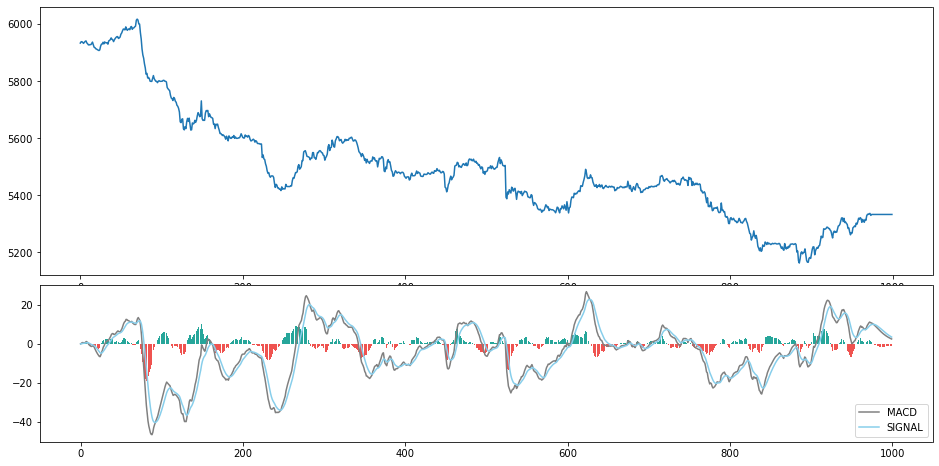

In [10]:
symbol = ['ADANIPORTS', 'APOLLOHOSP', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJFINANCE', 'BPCL',
          'BHARTIARTL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY', 'DIVISLAB', 'GRASIM'
         , 'HCLTECH', 'HDFC', 'HDFCBANK', 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK',
          'ITC', 'INDUSINDBK', 'INFY', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARUTI', 'NTPC', 'NESTLEIND', 'ONGC', 
          'POWERGRID', 'RELIANCE', 'SBILIFE', 'SBIN', 'SHREECEM', 'SUNPHARMA', 'TATAMOTORS', 'TATACONSUM', 'TATASTEEL', 
         'TCS', 'TECHM', 'TITAN', 'UPL', 'WIPRO', 'ULTRACEMCO']
print(len(symbol))
ch=0
pn=0
ln=0
p=0
l=0
tr=0
for i in symbol:
    #df = yf.download(i, start='2022-09-09', end='2022-09-10', interval='1m')
    print(i)
    df = pd.read_excel('data5min.xlsx', sheet_name = i).iloc[-1000:].reset_index()

    df3=df
    df4=df
    supertrend = Supertrend(df, 10, 3)
    df = df.join(supertrend)

    supertrend = Supertrend(df3, 20, 5)
    df3 = df3.join(supertrend)

    #supertrend = Supertrend(df4, 10, 1)
    #df4 = df4.join(supertrend)
    df2 = call(df)
    see(i, df, df2, df3)
    #MACD INDICATOR
    #df['EMA12'] = df['close'].ewm(span=12).mean()
    #df['EMA26'] = df['close'].ewm(span=26).mean()
    #df['MACD'] = df['EMA26'] - df['EMA12']
    #df['MACDSignalLine'] = df['MACD'].ewm(span=9).mean()
    #df['Histogram'] = df['MACD'] - df['MACDSignalLine']
    #macd(df)
    
    googl_macd = get_macd(df['close'], 26, 12, 9)
    googl_macd.tail()
    
    plot_macd(df['close'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])
    
    #print(googl_macd['hist'])

    c, pn1, ln1, p1, l1, tr1 = backtest_supertrend(df, 100000, i, googl_macd['hist'])
    ch=ch+c
    pn=pn+pn1
    ln=ln+ln1
    p=p+p1
    l=l+l1
    tr=tr+tr1
print(f'\nP/L: {ch}')
print(f'Total trades={tr}')
print(f'profitable trades: loss trades={pn}:{ln}')
if(ln+pn>0):
    print(f'Success %= {pn/(ln+pn)*100}%')
    print(f'Avg win:{p/pn}')
    print(f'Avg loss:{l/ln}')
    

In [31]:
%%time
pd.read_excel('data5min.xlsx', sheet_name = 'ADANIPORTS', skiprows = 82000)

CPU times: total: 16.8 s
Wall time: 16.9 s


81999 2022-06-08 11:50:00  732.85  733.25  732.45   732.8  53640
0    82000 2022-06-08 11:55:00  732.70  733.00  731.80  732.30  14360
1    82001 2022-06-08 12:00:00  732.30  733.10  731.40  732.85  16119
2    82002 2022-06-08 12:05:00  732.90  733.90  732.70  733.35  18547
3    82003 2022-06-08 12:10:00  733.35  733.40  731.40  732.45  14872
4    82004 2022-06-08 12:15:00  732.45  732.75  732.10  732.45   7107
..     ...                 ...     ...     ...     ...     ...    ...
664  82664 2022-06-20 17:15:00  663.15  663.15  663.15  663.15      0
665  82665 2022-06-20 17:20:00  663.15  663.15  663.15  663.15      0
666  82666 2022-06-20 17:30:00  663.15  663.15  663.15  663.15      0
667  82667 2022-06-20 18:15:00  663.15  663.15  663.15  663.15      0
668  82668 2022-06-20 18:50:00  663.15  663.15  663.15  663.15      0

[669 rows x 7 columns]

In [32]:
%%time
pd.read_excel('data5min.xlsx', sheet_name = 'ADANIPORTS')

CPU times: total: 17.3 s
Wall time: 17.4 s


Unnamed: 0                date    open    high     low   close  volume
0               0 2018-01-01 09:15:00  407.00  407.00  403.30  404.55   43220
1               1 2018-01-01 09:20:00  404.60  404.90  404.30  404.80    9068
2               2 2018-01-01 09:25:00  404.80  405.35  404.35  404.35    7767
3               3 2018-01-01 09:30:00  404.50  404.50  403.50  403.55   11129
4               4 2018-01-01 09:35:00  403.55  404.05  403.50  404.05    7058
...           ...                 ...     ...     ...     ...     ...     ...
82664       82664 2022-06-20 17:15:00  663.15  663.15  663.15  663.15       0
82665       82665 2022-06-20 17:20:00  663.15  663.15  663.15  663.15       0
82666       82666 2022-06-20 17:30:00  663.15  663.15  663.15  663.15       0
82667       82667 2022-06-20 18:15:00  663.15  663.15  663.15  663.15       0
82668       82668 2022-06-20 18:50:00  663.15  663.15  663.15  663.15       0

[82669 rows x 7 columns]

In [ ]:
for i in 